In [677]:
import pandas as pd
import numpy as np
from utils.const import *
from utils.physics import *
import matplotlib.pyplot as plt
from copy import copy
cmap = copy(plt.cm.get_cmap("jet"))
from scipy.optimize import least_squares

In [678]:
degree = r"${}^{\circ}$"
GeV = "GeV"
GeV2 = "GeV"+r"${}^{2}$"
GeVc = "GeV/c"
GeVc2 = "(GeV/c)"+r"${}^{2}$"

In [679]:
import matplotlib
# initial settings
pgf_with_latex = {
		"pgf.texsystem": "pdflatex",
		"text.usetex": True,            # use LaTeX to write all text
		"font.family": "sans-serif",         
		"font.sans-serif": "Helvetica",
		"font.size": 25,				# default font size
		"axes.labelsize": 24,			# x and y label size
		"axes.titlesize": 24,           # subfigure title size, i.e. title size when one figure
		"legend.fontsize": 22,			# legend size
		"xtick.labelsize": 23,			# x axis tick label size
		"ytick.labelsize": 23,			# y axis tick label 
		"figure.titlesize": 25,         # Figure title size, useful when you have multiple plots in one canvas.
		"pgf.preamble": r"\usepackage{xcolor}",     # xcolor for colours
		"figure.autolayout": True
}
matplotlib.rcParams.update(pgf_with_latex)

def nphistmean(hist, bins):
    s=0
    for i in range(len(hist)):
        s += hist[i] * ((bins[i] + bins[i+1]) / 2) 
    mean = s / np.sum(hist)
    return mean

In [709]:
parent_MC = "/Volumes/Extreme SSD/data/MC/convPkl/inbending/"
parent_Gen = "/Volumes/Extreme SSD/data/MC/raw_gen/inbending/"
parent_MC_bkg1g = "/Volumes/Extreme SSD/data/MC/convPkl/bkg_1g/"
parent_MC_bkg2g = "/Volumes/Extreme SSD/data/MC/convPkl/bkg_2g/"
parent_exp = "/Volumes/Extreme SSD/data/exp/convPkl/inb/"

# BH+DVCS
df_3063_corr = pd.read_pickle(parent_MC + "3063.pkl")
df_3066_corr = pd.read_pickle(parent_MC + "3066.pkl")
df_3067_corr = pd.read_pickle(parent_MC + "3067.pkl")
df_3073_corr = pd.read_pickle(parent_MC + "3073.pkl")

# pi0 bkg
df_3284_1g_corr = pd.read_pickle(parent_MC_bkg1g + "3284.pkl")
df_3292_1g_corr = pd.read_pickle(parent_MC_bkg1g + "3292.pkl")

# pi0 sig
df_3284_2g_corr = pd.read_pickle(parent_MC_bkg2g + "3284.pkl")
df_3292_2g_corr = pd.read_pickle(parent_MC_bkg2g + "3292.pkl")

# sig+bkg
exp_1g_corr = pd.read_pickle(parent_exp + "dvcs_inb_corr.pkl")

# pi0->2g
exp_2g_corr = pd.read_pickle(parent_exp + "pi0_inb_corr.pkl")

In [710]:
dvcsSimInb = pd.concat([df_3063_corr, df_3066_corr, df_3067_corr, df_3073_corr])
bkgSimInb = pd.concat([df_3284_1g_corr, df_3292_1g_corr])
pi0SimInb = pd.concat([df_3284_2g_corr, df_3292_2g_corr])

In [711]:
def saveT2Phi2(df_epgg):
    #set up pi0 variables
    # useful objects
    ele = [df_epgg['Epx'], df_epgg['Epy'], df_epgg['Epz']]

    gam = [df_epgg['Gpx'], df_epgg['Gpy'], df_epgg['Gpz']]


    VGS = [-df_epgg['Epx'], -df_epgg['Epy'], pbeam - df_epgg['Epz']]
    v3l = cross(beam, ele)
    v3g = cross(VGS, gam)
    costheta = cosTheta(VGS, gam)

    # binning kinematics
    df_epgg.loc[:,'t2'] = (M * df_epgg['Q2'] + 2 * M * df_epgg['nu'] * (df_epgg['nu'] - np.sqrt(df_epgg['nu'] * df_epgg['nu'] + df_epgg['Q2']) * costheta))\
    / (M + df_epgg['nu'] - np.sqrt(df_epgg['nu'] * df_epgg['nu'] + df_epgg['Q2']) * costheta)
    df_epgg.loc[:,'phi2'] = angle(v3l, v3g)
    df_epgg.loc[:,'phi2'] = np.where(dot(v3l, gam) <
                              0, 360.0 - df_epgg['phi2'], df_epgg['phi2'])
    
    df_epgg = df_epgg.rename(columns = {"t": "t1"})
    return df_epgg

In [712]:
pi0SimInb = saveT2Phi2(pi0SimInb)
exp_2g_corr = saveT2Phi2(exp_2g_corr)

In [713]:
bkgSimInb.loc[:, "GenGpx2"] = - bkgSimInb.GenEpx - bkgSimInb.GenPpx - bkgSimInb.GenGpx
bkgSimInb.loc[:, "GenGpy2"] = - bkgSimInb.GenEpy - bkgSimInb.GenPpy - bkgSimInb.GenGpy
bkgSimInb.loc[:, "GenGpz2"] = 10.6 - bkgSimInb.GenEpz - bkgSimInb.GenPpz - bkgSimInb.GenGpz
Gengam2 = [bkgSimInb.GenGpx2, bkgSimInb.GenGpy2, bkgSimInb.GenGpz2]
bkgSimInb.loc[:, "GenGp2"] = mag(Gengam2)

df_gammaGencopy = copy(bkgSimInb)
df_gammaGencopy.loc[:, "GenGp"] = np.where(bkgSimInb["GenGp"]>bkgSimInb["GenGp2"], bkgSimInb.loc[:, "GenGp"], bkgSimInb.loc[:, "GenGp2"])
df_gammaGencopy.loc[:, "GenGpx"] = np.where(bkgSimInb["GenGp"]>bkgSimInb["GenGp2"], bkgSimInb.loc[:, "GenGpx"], bkgSimInb.loc[:, "GenGpx2"])
df_gammaGencopy.loc[:, "GenGpy"] = np.where(bkgSimInb["GenGp"]>bkgSimInb["GenGp2"], bkgSimInb.loc[:, "GenGpy"], bkgSimInb.loc[:, "GenGpy2"])
df_gammaGencopy.loc[:, "GenGpz"] = np.where(bkgSimInb["GenGp"]>bkgSimInb["GenGp2"], bkgSimInb.loc[:, "GenGpz"], bkgSimInb.loc[:, "GenGpz2"])
df_gammaGencopy.loc[:, "GenGp2"] = np.where(bkgSimInb["GenGp"]>bkgSimInb["GenGp2"], bkgSimInb.loc[:, "GenGp2"], bkgSimInb.loc[:, "GenGp"])
df_gammaGencopy.loc[:, "GenGpx2"] = np.where(bkgSimInb["GenGp"]>bkgSimInb["GenGp2"], bkgSimInb.loc[:, "GenGpx2"], bkgSimInb.loc[:, "GenGpx"])
df_gammaGencopy.loc[:, "GenGpy2"] = np.where(bkgSimInb["GenGp"]>bkgSimInb["GenGp2"], bkgSimInb.loc[:, "GenGpy2"], bkgSimInb.loc[:, "GenGpy"])
df_gammaGencopy.loc[:, "GenGpz2"] = np.where(bkgSimInb["GenGp"]>bkgSimInb["GenGp2"], bkgSimInb.loc[:, "GenGpz2"], bkgSimInb.loc[:, "GenGpz"])
bkgSimInb = df_gammaGencopy

Gengam = [bkgSimInb.GenGpx, bkgSimInb.GenGpy, bkgSimInb.GenGpz]
bkgSimInb.loc[:, "GenGphi"] = getPhi(Gengam)
bkgSimInb.loc[:, "GenGtheta"] = getTheta(Gengam)
Gengam2 = [bkgSimInb.GenGpx2, bkgSimInb.GenGpy2, bkgSimInb.GenGpz2]
bkgSimInb.loc[:, "GenGphi2"] = getPhi(Gengam2)
bkgSimInb.loc[:, "GenGtheta2"] = getTheta(Gengam2)

In [715]:
epgExpInbFD = copy(exp_1g_corr.loc[(exp_1g_corr.Ee>2)&(exp_1g_corr.Ge>2)&((exp_1g_corr.Psector<7)&(exp_1g_corr.Ptheta<32))& (exp_1g_corr.Gsector<7)])
pi0ExpInbFD = copy(exp_2g_corr.loc[(exp_2g_corr.Ee>2)&(exp_2g_corr.Ge>2)&((exp_2g_corr.Psector<7)&(exp_2g_corr.Ptheta<32))& (exp_2g_corr.Gsector<7)])
dvcsSimInbFD = copy(dvcsSimInb.loc[(dvcsSimInb.Ee>2)&(dvcsSimInb.Ge>2)&((dvcsSimInb.Psector<7)&(dvcsSimInb.Ptheta<32))& (dvcsSimInb.Gsector<7)])
bkgSimInbFD = copy(bkgSimInb.loc[(bkgSimInb.Ee>2)&(bkgSimInb.Ge>2)&((bkgSimInb.Psector<7)&(bkgSimInb.Ptheta<32))& (bkgSimInb.Gsector<7)])
pi0SimInbFD = copy(pi0SimInb.loc[(pi0SimInb.Ee>2)&(pi0SimInb.Ge>2)&((pi0SimInb.Psector<7)&(pi0SimInb.Ptheta<32))& (pi0SimInb.Gsector<7)& (pi0SimInb.Gsector2<7)])

epgExpInbCD = copy(exp_1g_corr.loc[(exp_1g_corr.Ee>2)&(exp_1g_corr.Ge>2)&(exp_1g_corr.Pp>0.4)&(exp_1g_corr.Pp<0.8)&((exp_1g_corr.Psector>7)&(exp_1g_corr.Ptheta<60))& (exp_1g_corr.Gsector<7)])
pi0ExpInbCD = copy(exp_2g_corr.loc[(exp_2g_corr.Ee>2)&(exp_2g_corr.Ge>2)&(exp_2g_corr.Pp>0.4)&(exp_2g_corr.Pp<0.8)&((exp_2g_corr.Psector>7)&(exp_2g_corr.Ptheta<60))& (exp_2g_corr.Gsector<7)& (exp_2g_corr.Gsector2<7)])
dvcsSimInbCD = copy(dvcsSimInb.loc[(dvcsSimInb.Ee>2)&(dvcsSimInb.Ge>2)&(dvcsSimInb.Pp>0.4)&(dvcsSimInb.Pp<0.8)&((dvcsSimInb.Psector>7)&(dvcsSimInb.Ptheta<60))& (dvcsSimInb.Gsector<7)])
bkgSimInbCD = copy(bkgSimInb.loc[(bkgSimInb.Ee>2)&(bkgSimInb.Ge>2)&(bkgSimInb.Pp>0.4)&(bkgSimInb.Pp<0.8)&((bkgSimInb.Psector>7)&(bkgSimInb.Ptheta<60))& (bkgSimInb.Gsector<7)])
pi0SimInbCD = copy(pi0SimInb.loc[(pi0SimInb.Ee>2)&(pi0SimInb.Ge>2)&(pi0SimInb.Pp>0.4)&(pi0SimInb.Pp<0.8)&((pi0SimInb.Psector>7)&(pi0SimInb.Ptheta<60))& (pi0SimInb.Gsector<7)])

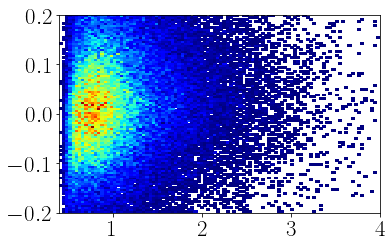

In [565]:
pi0ExpInbFD = exp_2g_corr.loc[(exp_2g_corr.Ee>3)&(exp_2g_corr.Ge>2)&((exp_2g_corr.Psector<7)&(exp_2g_corr.Ptheta<32))& (exp_2g_corr.Gsector<7)]
plt.hist2d(pi0ExpInbFD.Pp, pi0ExpInbFD.MM2_ep, bins = [np.linspace(0.4, 4, 101), np.linspace(-0.2, 0.2, 101)], cmin = 1, cmap = cmap)
plt.show()

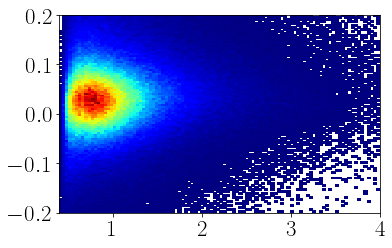

In [566]:
plt.hist2d(pi0SimInbFD.Pp, pi0SimInbFD.MM2_ep, bins = [np.linspace(0.4, 4, 101), np.linspace(-0.2, 0.2, 101)], cmin = 1, cmap = cmap)
plt.show()

In [362]:
epgExpInbCDFT = exp_1g_corr.loc[(exp_1g_corr.Ee>3)&(exp_1g_corr.Ge>2)&(exp_1g_corr.Pp>0.4)&(exp_1g_corr.Pp<0.8)&((exp_1g_corr.Psector>7)&(exp_1g_corr.Ptheta<60))& (exp_1g_corr.Gsector>7)]
pi0ExpInbCDFT = exp_2g_corr.loc[(exp_2g_corr.Ee>3)&(exp_2g_corr.Ge>2)&(exp_2g_corr.Pp>0.4)&(exp_2g_corr.Pp<0.8)&((exp_2g_corr.Psector>7)&(exp_2g_corr.Ptheta<60))& (exp_2g_corr.Gsector>7)& (exp_2g_corr.Gsector2>7)]
dvcsSimInbCDFT = dvcsSimInb.loc[(dvcsSimInb.Ee>3)&(dvcsSimInb.Ge>2)&(dvcsSimInb.Pp>0.4)&(dvcsSimInb.Pp<0.8)&((dvcsSimInb.Psector>7)&(dvcsSimInb.Ptheta<60))& (dvcsSimInb.Gsector>7)]
bkgSimInbCDFT = bkgSimInb.loc[(bkgSimInb.Ee>3)&(bkgSimInb.Ge>2)&(bkgSimInb.Pp>0.4)&(bkgSimInb.Pp<0.8)&((bkgSimInb.Psector>7)&(bkgSimInb.Ptheta<60))& (bkgSimInb.Gsector>7)]
pi0SimInbCDFT = pi0SimInb.loc[(pi0SimInb.Ee>3)&(pi0SimInb.Ge>2)&(pi0SimInb.Pp>0.4)&(pi0SimInb.Pp<0.8)&((pi0SimInb.Psector>7)&(pi0SimInb.Ptheta<60))& (pi0SimInb.Gsector>7)]

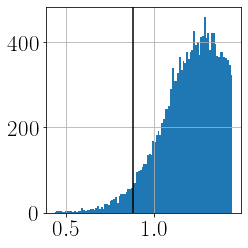

In [404]:
# binstarts = [20, 0, 0, -0.5, -0.04, 0.1,-0.4 , 0]
# binends = [60, 1.1, 10, 1.2, 0.04, 1.7, 0.4, 0.12]
fig, axs = plt.subplots(1, 1, figsize = (4, 4))
for yind in range(0, 1):
    for xind in range(0, 1):
        ind = yind
        start = M-0.5 # binstarts[ind]
        end = M+0.5 #binends[ind]
        bins = np.linspace(start, end, 101)
        epgExpInbCDFT.loc[:, "MM2_eg"].hist(bins = bins, ax = axs)
        axs.axvline(M**2, color = 'k')

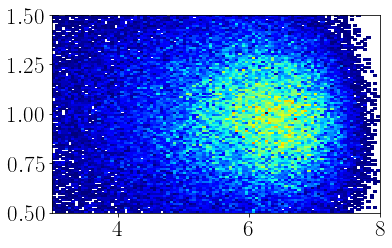

In [23]:
plt.hist2d(pi0ExpInbFD.Ep, pi0ExpInbFD.MM2_egg, bins = [np.linspace(3, 8, 101), np.linspace(0.5, 1.5, 101)], cmin = 1, cmap = cmap)
plt.show()

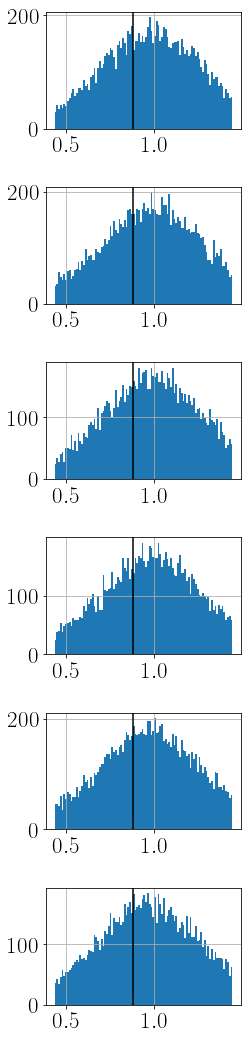

In [35]:
# binstarts = [20, 0, 0, -0.5, -0.04, 0.1,-0.4 , 0]
# binends = [60, 1.1, 10, 1.2, 0.04, 1.7, 0.4, 0.12]
fig, axs = plt.subplots(6, 1, figsize = (4, 15))
for yind in range(0, 6):
    for xind in range(0, 1):
        ind = yind
        start = M-0.5 # binstarts[ind]
        end = M+0.5 #binends[ind]
        bins = np.linspace(start, end, 101)
        pi0ExpInbFD.loc[pi0ExpInbFD.Psector == ind+1, "MM2_egg"].hist(bins = bins, ax = axs[ind])
        axs[ind].axvline(M**2, color = 'k')

In [1]:
plt.hist2d(bkgSimInbFD.GenGphi2, bkgSimInbFD.GenGtheta2, bins = [np.linspace(-180, 180, 361), np.linspace(0, 50, 101)], cmap = cmap, cmin = 1)
plt.title("DV"+r"$\pi^0"+"P, DVCS misidentified")
plt.xlabel(r"$\phi_{\gamma 2}$"+" generated")
plt.ylabel(r"$\theta_{\gamma 2}$"+" generated")
plt.show()


SyntaxError: invalid syntax (<ipython-input-1-16a0cec53850>, line 2)

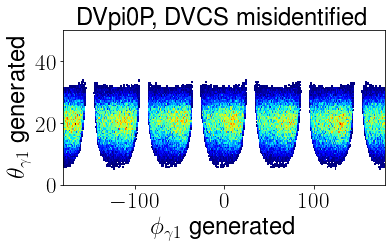

In [321]:
plt.hist2d(bkgSimInbFD.GenGphi, bkgSimInbFD.GenGtheta, bins = [np.linspace(-180, 180, 361), np.linspace(0, 50, 101)], cmap = cmap, cmin = 1)
plt.title("DVpi0P, DVCS misidentified")
plt.xlabel(r"$\phi_{\gamma 1}$"+" generated")
plt.ylabel(r"$\theta_{\gamma 1}$"+" generated")
plt.show()


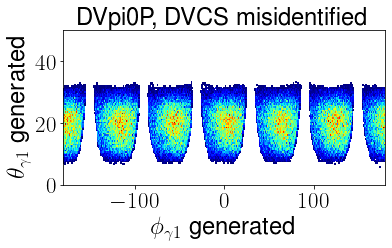

In [324]:
plt.hist2d(dvcsSimInbFD.GenGphi, dvcsSimInbFD.GenGtheta, bins = [np.linspace(-180, 180, 361), np.linspace(0, 50, 101)], cmap = cmap, cmin = 1)
plt.title("DVpi0P, DVCS misidentified")
plt.xlabel(r"$\phi_{\gamma 1}$"+" generated")
plt.ylabel(r"$\theta_{\gamma 1}$"+" generated")
plt.show()


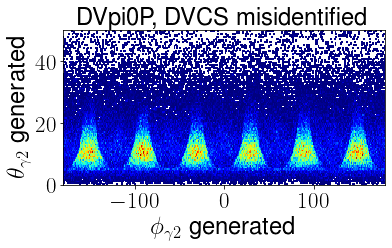

In [322]:
plt.hist2d(bkgSimInbCD.GenGphi2, bkgSimInbCD.GenGtheta2, bins = [np.linspace(-180, 180, 361), np.linspace(0, 50, 101)], cmap = cmap, cmin = 1)
plt.title("DVpi0P, DVCS misidentified")
plt.xlabel(r"$\phi_{\gamma 2}$"+" generated")
plt.ylabel(r"$\theta_{\gamma 2}$"+" generated")
plt.show()


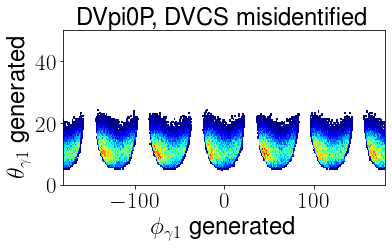

In [325]:
plt.hist2d(bkgSimInbCD.Gphi, bkgSimInbCD.Gtheta, bins = [np.linspace(-180, 180, 361), np.linspace(0, 50, 101)], cmap = cmap, cmin = 1)
plt.title("DVpi0P, DVCS misidentified")
plt.xlabel(r"$\phi_{\gamma 1}$"+" generated")
plt.ylabel(r"$\theta_{\gamma 1}$"+" generated")
plt.show()


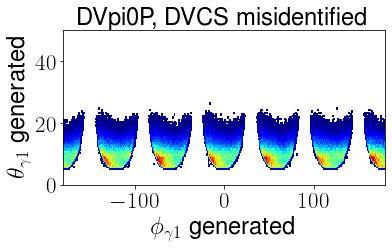

In [326]:
plt.hist2d(dvcsSimInbCD.GenGphi, dvcsSimInbCD.GenGtheta, bins = [np.linspace(-180, 180, 361), np.linspace(0, 50, 101)], cmap = cmap, cmin = 1)
plt.title("DVpi0P, DVCS misidentified")
plt.xlabel(r"$\phi_{\gamma 1}$"+" generated")
plt.ylabel(r"$\theta_{\gamma 1}$"+" generated")
plt.show()


In [281]:
print(len(epgExpInbFD), len(pi0ExpInbFD))

59099 77529


In [253]:
print(len(epgExpInbCD), len(pi0ExpInbCD))

112801 36960


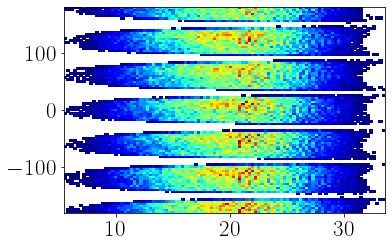

In [271]:
plt.hist2d(bkgSimInbFD.Gtheta, bkgSimInbFD.Gphi, bins = 101, cmap = cmap, cmin = 1)
plt.show()

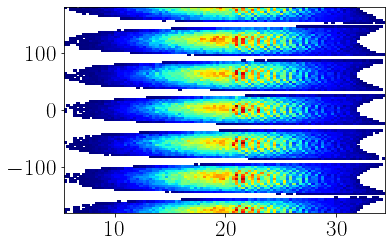

In [272]:
plt.hist2d(pi0SimInbFD.Gtheta, pi0SimInbFD.Gphi, bins = 101, cmap = cmap, cmin = 1)
plt.show()

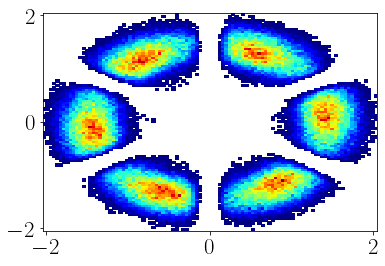

In [22]:
plt.hist2d(dvcsSimInbFD.Gpx, dvcsSimInbFD.Gpy, bins = 101, cmap = cmap, cmin = 1)
plt.show()

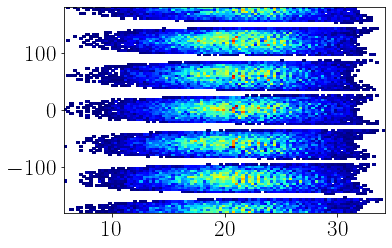

In [270]:
plt.hist2d(pi0ExpInbFD.Gtheta, pi0ExpInbFD.Gphi, bins = 101, cmap = cmap, cmin = 1)
plt.show()

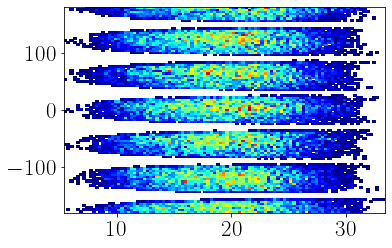

In [269]:
plt.hist2d(epgExpInbFD.Gtheta, epgExpInbFD.Gphi, bins = 101, cmap = cmap, cmin = 1)
plt.show()

In [21]:
len(dvcsSimInbFD)

47165

In [15]:
def dfinOneBin(df, lower_xB, upper_xB, lower_Q2, upper_Q2, lower_t, upper_t, lower_phi, upper_phi):
    cond_lower_Q2 = df["Q2"] >= lower_Q2
    cond_upper_Q2 = df["Q2"] < upper_Q2
    cond_lower_xB = df["xB"] >= lower_xB
    cond_upper_xB = df["xB"] < upper_xB
    cond_lower_t = df["t2"] >= lower_t
    cond_upper_t = df["t2"] < upper_t
    cond_lower_phi = df["phi1"] >= lower_phi
    cond_upper_phi = df["phi1"] < upper_phi

    return df[cond_lower_xB & cond_upper_xB & cond_lower_Q2 & cond_upper_Q2 & cond_lower_phi & cond_upper_phi & cond_lower_t & cond_upper_t]

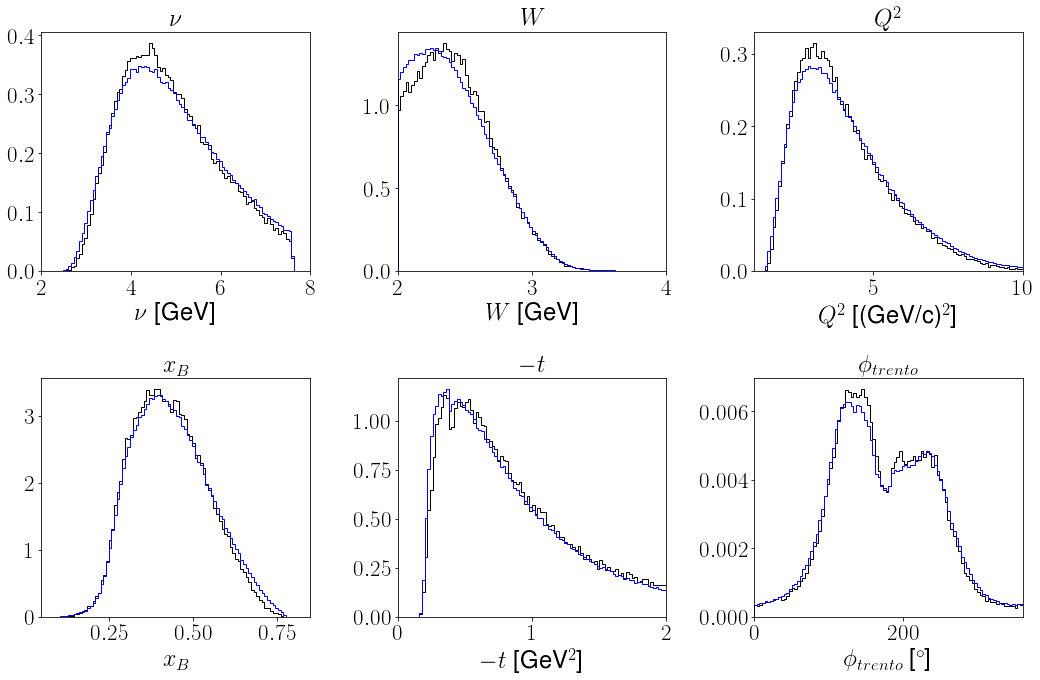

In [254]:
varstoplot = ["nu", "W", "Q2", "xB", "t1", "phi1"]
title = [r"$\nu$", r"$W$", r"$Q^{2}$", r"$x_{B}$", r"$-t$", r"$\phi_{trento}$" ]
unit = [GeV, GeV, GeVc2, None, GeV2, degree, GeV2, degree]
binstarts = [2, 2, 1, 0.05, 0, 0]
binends = [8, 4, 10, 0.85, 2, 360]
fig, axs = plt.subplots(2, 3, figsize = (15, 10))
for xind in range(0,3):
    for yind in range(0, 2):
        ind =xind+3*yind
        start = binstarts[ind]
        end = binends[ind]
        bins = np.linspace(start, end, 101)
        axs[yind, xind].hist(pi0ExpInbFD.loc[:, varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', density=True, linewidth=1)
        axs[yind, xind].hist(pi0SimInbFD.loc[:, varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='b', density=True, linewidth=1)
        axs[yind, xind].set_title(title[ind])
        axs[yind, xind].set_xlim([start, end])
        if (unit[ind]):
            axs[yind, xind].set_xlabel(title[ind]+" [" + unit[ind] +"]")
        else:
            axs[yind, xind].set_xlabel(title[ind])
plt.show()

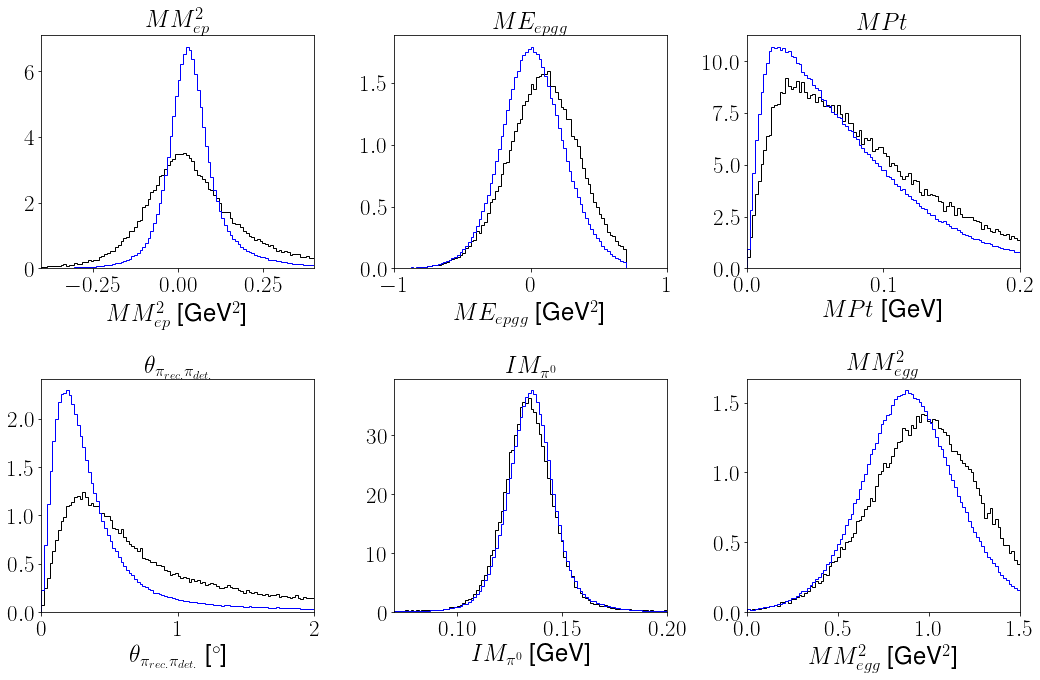

In [14]:
varstoplot = ["MM2_ep", "ME_epgg", "MPt", "reconPi", "Mpi0", "MM2_egg"]
title = [r"$MM^{2}_{ep}$", r"$ME_{epgg}$", r"$MPt$", r"$\theta_{\pi_{rec.}\pi_{det.}}$", r"$IM_{\pi^0}$", r"$MM^2_{egg}$" ]
unit = [GeV2, GeV2, GeV, degree, GeV, GeV2, GeV, "cm"]
binstarts = [-0.4, -1, 0, 0, 0.07, 0]
binends = [0.4, 1, 0.2, 2, 0.2, 1.5]
fig, axs = plt.subplots(2, 3, figsize = (15, 10))
for xind in range(0,3):
    for yind in range(0, 2):
        ind =xind+3*yind
        start = binstarts[ind]
        end = binends[ind]
        bins = np.linspace(start, end, 101)
        axs[yind, xind].hist(pi0ExpInbFD.loc[:, varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', density=True, linewidth=1)
        axs[yind, xind].hist(pi0SimInbFD.loc[:, varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='b', density=True, linewidth=1)
        axs[yind, xind].set_title(title[ind])
        axs[yind, xind].set_xlim([start, end])
        if (unit[ind]):
            axs[yind, xind].set_xlabel(title[ind]+" [" + unit[ind] +"]")
        else:
            axs[yind, xind].set_xlabel(title[ind])
plt.show()

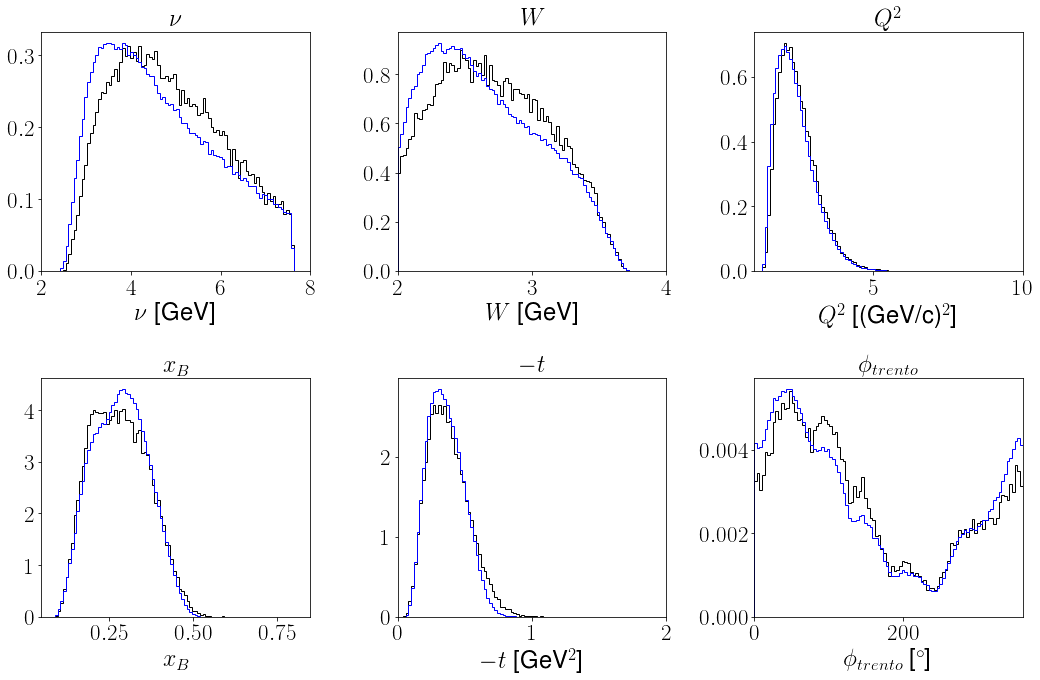

In [255]:
varstoplot = ["nu", "W", "Q2", "xB", "t2", "phi1"]
title = [r"$\nu$", r"$W$", r"$Q^{2}$", r"$x_{B}$", r"$-t$", r"$\phi_{trento}$" ]
unit = [GeV, GeV, GeVc2, None, GeV2, degree, GeV2, degree]
binstarts = [2, 2, 1, 0.05, 0, 0]
binends = [8, 4, 10, 0.85, 2, 360]
fig, axs = plt.subplots(2, 3, figsize = (15, 10))
for xind in range(0,3):
    for yind in range(0, 2):
        ind =xind+3*yind
        start = binstarts[ind]
        end = binends[ind]
        bins = np.linspace(start, end, 101)
        axs[yind, xind].hist(pi0ExpInbCD.loc[:, varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', density=True, linewidth=1)
        axs[yind, xind].hist(pi0SimInbCD.loc[:, varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='b', density=True, linewidth=1)
        axs[yind, xind].set_title(title[ind])
        axs[yind, xind].set_xlim([start, end])
        if (unit[ind]):
            axs[yind, xind].set_xlabel(title[ind]+" [" + unit[ind] +"]")
        else:
            axs[yind, xind].set_xlabel(title[ind])
plt.show()

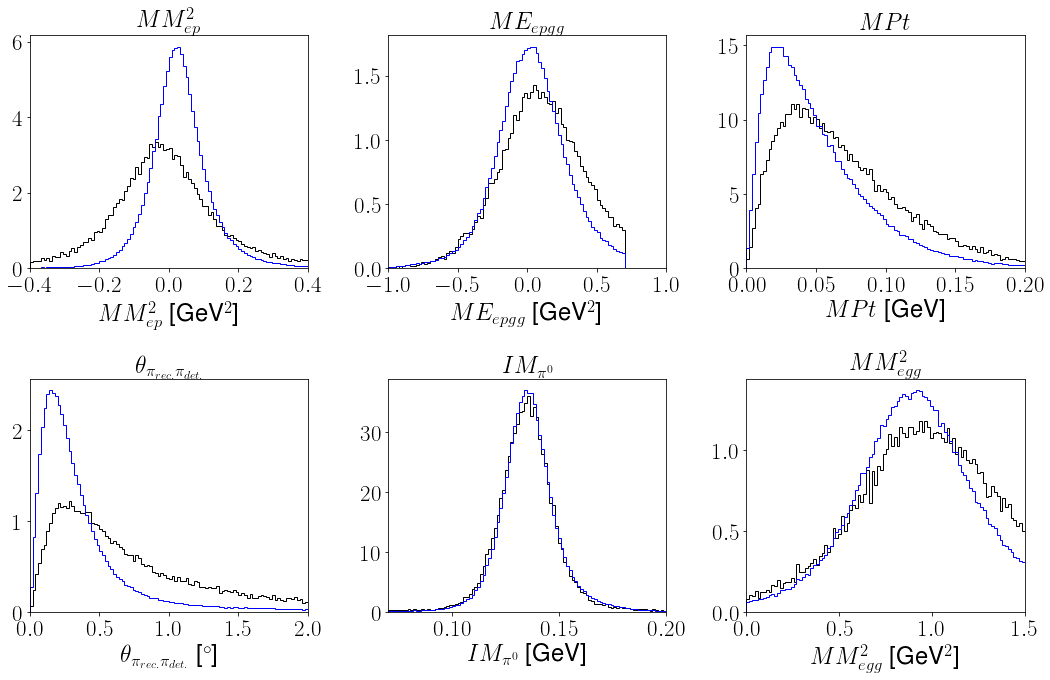

In [15]:
varstoplot = ["MM2_ep", "ME_epgg", "MPt", "reconPi", "Mpi0", "MM2_egg"]
title = [r"$MM^{2}_{ep}$", r"$ME_{epgg}$", r"$MPt$", r"$\theta_{\pi_{rec.}\pi_{det.}}$", r"$IM_{\pi^0}$", r"$MM^2_{egg}$" ]
unit = [GeV2, GeV2, GeV, degree, GeV, GeV2, GeV, "cm"]
binstarts = [-0.4, -1, 0, 0, 0.07, 0]
binends = [0.4, 1, 0.2, 2, 0.2, 1.5]
fig, axs = plt.subplots(2, 3, figsize = (15, 10))
for xind in range(0,3):
    for yind in range(0, 2):
        ind =xind+3*yind
        start = binstarts[ind]
        end = binends[ind]
        bins = np.linspace(start, end, 101)
        axs[yind, xind].hist(pi0ExpInbCD.loc[:, varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', density=True, linewidth=1)
        axs[yind, xind].hist(pi0SimInbCD.loc[:, varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='b', density=True, linewidth=1)
        axs[yind, xind].set_title(title[ind])
        axs[yind, xind].set_xlim([start, end])
        if (unit[ind]):
            axs[yind, xind].set_xlabel(title[ind]+" [" + unit[ind] +"]")
        else:
            axs[yind, xind].set_xlabel(title[ind])
plt.show()

In [22]:
contCD = len(pi0ExpInbCD)*len(bkgSimInbCD)/len(pi0SimInbCD)/len(epgExpInbCD)
contFD = len(pi0ExpInbFD)*len(bkgSimInbFD)/len(pi0SimInbFD)/len(epgExpInbFD)
print(contFD, contCD)

0.43188115199359634 0.18266904199111794


nu 5.189340702178969
xB 0.42353464127592294
W 2.5233932402184505
t2 0.677581278065937
Q2 4.1632905793296215
phi2 174.52967010349488


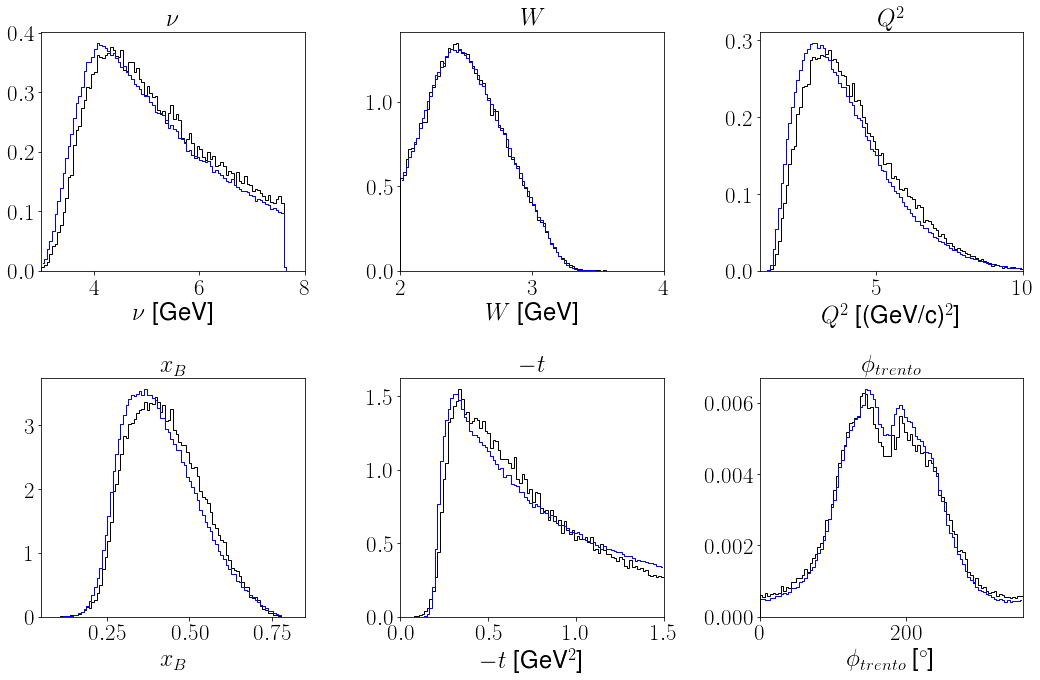

<Figure size 432x288 with 0 Axes>

In [23]:
varstoplot = ["nu", "W", "Q2", "xB", "t2", "phi2"]
title = [r"$\nu$", r"$W$", r"$Q^{2}$", r"$x_{B}$", r"$-t$", r"$\phi_{trento}$" ]
unit = [GeV, GeV, GeVc2, None, GeV2, degree, GeV2, degree]
binstarts = [3, 2, 1, 0.05, 0, 0]
binends = [8, 4, 10, 0.85, 1.5, 360]
fig, axs = plt.subplots(2, 3, figsize = (15, 10))
for xind in range(0,3):
    for yind in range(0, 2):
        ind =xind+3*yind
        start = binstarts[ind]
        end = binends[ind]
        bins = np.linspace(start, end, 101)
        simDist_dvpi0, bins = np.histogram(bkgSimInbFD[varstoplot[ind]], bins, density = True)
        simDist_dvcs, bins = np.histogram(dvcsSimInbFD[varstoplot[ind]], bins, density = True)
#         simDist = len_pi0ExpInbFD/len_pi0SimInbFD*simDist_dvpi0 + (len_epgExpInbFD/len_dvcsSimInbFD-len_bkgSimInbFD/len_pi0SimInbFD*len_pi0ExpInbFD/len_dvcsSimInbFD)*simDist_dvcs
        simDist = (1-contFD)*simDist_dvcs + contFD*simDist_dvpi0
        expDist, bins = np.histogram(epgExpInbFD[varstoplot[ind]], bins, density=True)
        bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
        axs[yind, xind].step(bincenters, simDist, where='mid',color='b', linewidth=1)
#         axs[yind, xind].step(bincenters, c*simDist_dvpi0, where='mid',color='g', linewidth=1)
#         axs[yind, xind].step(bincenters, (1/len_dvcsSimInbFD-cont_inb_FD/len_dvcsSimInbFD)*len_epgExpInbFD*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].hist(epgExpInbFD[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', density=True, linewidth=1)
#         axs[yind, xind].hist(epgExpInbFD[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', linewidth=1)
#         axs[yind, xind].step(bincenters, expDist - len_pi0ExpInbFD/len_pi0SimInbFD*simDist_dvpi0, where='mid',color='k', linewidth=1)
        print(varstoplot[ind], nphistmean(expDist - len(pi0ExpInbFD)/len(pi0SimInbFD)*simDist_dvpi0, bins))
#         axs[yind, xind].step(bincenters, (1-c)*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].set_title(title[ind])
        axs[yind, xind].set_xlim([start, end])
        if (unit[ind]):
            axs[yind, xind].set_xlabel(title[ind]+" [" + unit[ind] +"]")
        else:
            axs[yind, xind].set_xlabel(title[ind])
# axs[0,2].set_xticks([2.2, 2.7, 3.2])
# axs[1,0].set_xticks([0.29, 0.32, 0.35, 0.38])
# axs[1,1].set_xticks([0.23, 0.3, 0.39, 0.52])
# axs[1,2].set_xticks([0, 90, 180, 270, 360])
plt.tight_layout()
# plt.savefig("kineFD.pdf")
# plt.savefig("analysisnote/inbending1.pdf")
plt.show()
plt.clf()

coneAngle 34.906631382424905
reconGam 0.7684659342455802
coplanarity 3.305362400949533
ME_epg 0.2814660381611747
MM2_epg -0.0007029902108986816
MM2_eg 1.120903066447511
MM2_ep 0.052465206511068195
MPt 0.06191089428235162


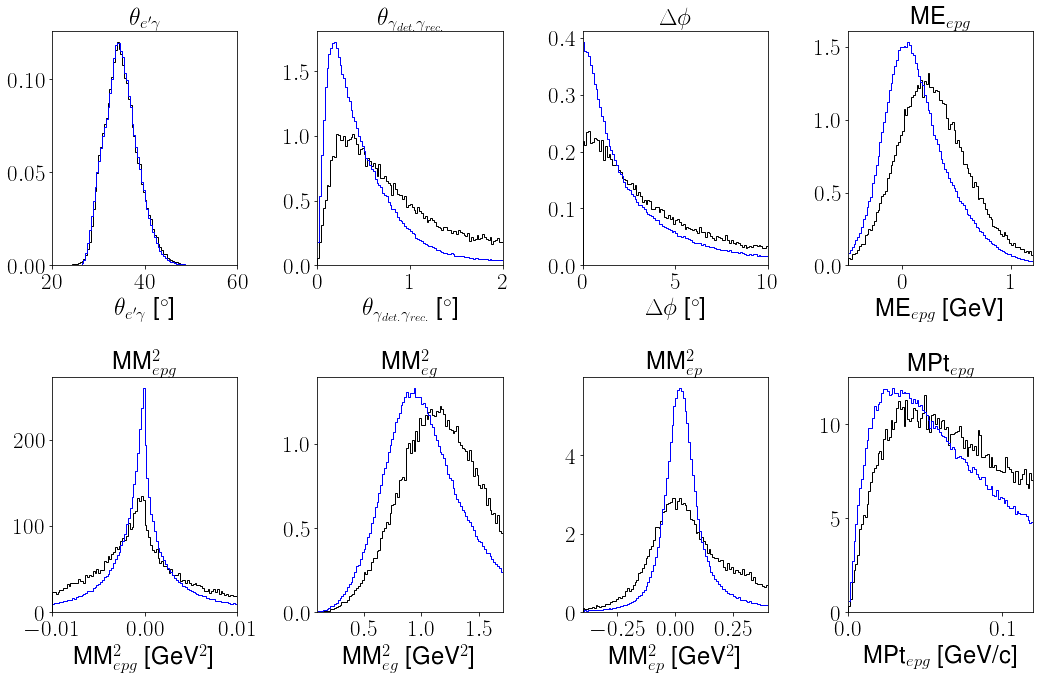

<Figure size 432x288 with 0 Axes>

In [24]:
varstoplot = ["coneAngle", "reconGam", "coplanarity", "ME_epg", "MM2_epg", "MM2_eg", "MM2_ep", "MPt"]
title = [r"$\theta_{e'\gamma}$", r"$\theta_{\gamma_{det.}\gamma_{rec.}}$", r"$\Delta\phi$" , "ME"+r"${}_{epg}$", "MM"+r"${}^{2}_{epg}$", "MM"+r"${}^{2}_{eg}$", "MM"+r"${}^{2}_{ep}$", "MPt"+r"${}_{epg}$"]
unit = [degree, degree, degree, GeV, GeV2, GeV2, GeV2, GeVc]
binstarts = [20, 0, 0, -0.5, -0.01, 0.1,-0.4 , 0]
binends = [60, 2, 10, 1.2, 0.01, 1.7, 0.4, 0.12]
fig, axs = plt.subplots(2, 4, figsize = (15,10))
for yind in range(0, 2):
    for xind in range(0,4):
        ind = 4*yind + xind
        start = binstarts[ind]
        end = binends[ind]
        bins = np.linspace(start, end, 101)
        simDist_dvpi0, bins = np.histogram(bkgSimInbFD[varstoplot[ind]], bins, density = True)
        simDist_dvcs, bins = np.histogram(dvcsSimInbFD[varstoplot[ind]], bins, density = True)
#         simDist = len_pi0ExpInbFD/len_pi0SimInbFD*simDist_dvpi0 + (len_epgExpInbFD/len_dvcsSimInbFD-len_bkgSimInbFD/len_pi0SimInbFD*len_pi0ExpInbFD/len_dvcsSimInbFD)*simDist_dvcs
        simDist = (1-contFD)*simDist_dvcs + contFD*simDist_dvpi0
        expDist, bins = np.histogram(epgExpInbFD[varstoplot[ind]], bins, density=True)
        bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
        axs[yind, xind].step(bincenters, simDist, where='mid',color='b', linewidth=1)
#         axs[yind, xind].step(bincenters, c*simDist_dvpi0, where='mid',color='g', linewidth=1)
#         axs[yind, xind].step(bincenters, (1/len_dvcsSimInbFD-cont_inb_FD/len_dvcsSimInbFD)*len_epgExpInbFD*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].hist(epgExpInbFD[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', density=True, linewidth=1)
#         axs[yind, xind].hist(epgExpInbFD[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', linewidth=1)
#         axs[yind, xind].step(bincenters, expDist - len_pi0ExpInbFD/len_pi0SimInbFD*simDist_dvpi0, where='mid',color='k', linewidth=1)
        print(varstoplot[ind], nphistmean(expDist - len(pi0ExpInbFD)/len(pi0SimInbFD)*simDist_dvpi0, bins))
#         axs[yind, xind].step(bincenters, (1-c)*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].set_title(title[ind])
        axs[yind, xind].set_xlim([start, end])
        if (unit[ind]):
            axs[yind, xind].set_xlabel(title[ind]+" [" + unit[ind] +"]")
        else:
            axs[yind, xind].set_xlabel(title[ind])
# axs[0,2].set_xticks([2.2, 2.7, 3.2])
# axs[1,0].set_xticks([0.29, 0.32, 0.35, 0.38])
# axs[1,1].set_xticks([0.23, 0.3, 0.39, 0.52])
# axs[1,2].set_xticks([0, 90, 180, 270, 360])
plt.tight_layout()
# plt.savefig("kineFD.pdf")
# plt.savefig("analysisnote/inbending1.pdf")
plt.show()
plt.clf()

ME_epg 0.2814660381611747
MM2_epg -0.0007029902108986816
MM2_eg 1.120903066447511
MM2_ep 0.052465206511068195


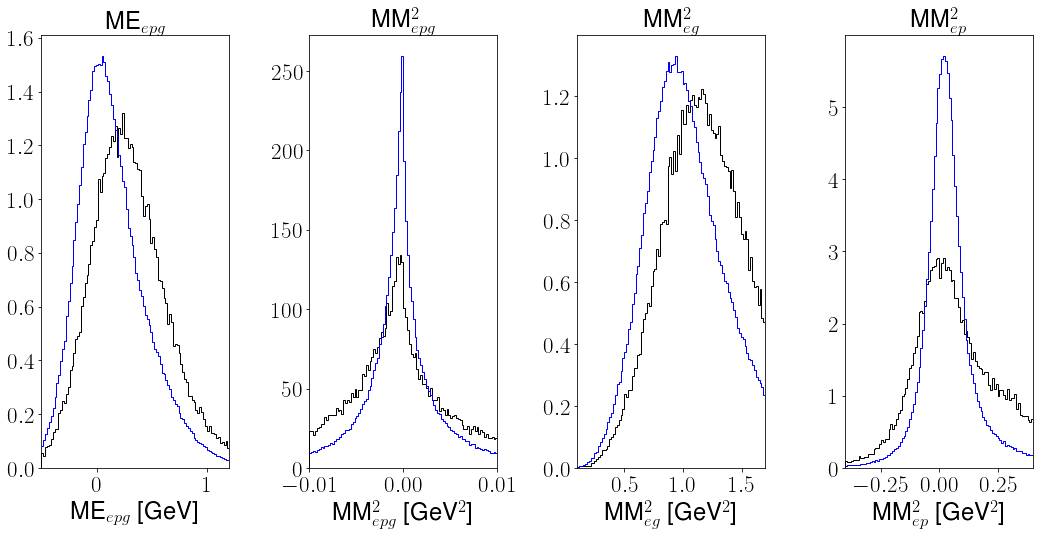

<Figure size 432x288 with 0 Axes>

In [761]:
varstoplot = ["ME_epg", "MM2_epg", "MM2_eg", "MM2_ep", "MPt"]
title = ["ME"+r"${}_{epg}$", "MM"+r"${}^{2}_{epg}$", "MM"+r"${}^{2}_{eg}$", "MM"+r"${}^{2}_{ep}$", "MPt"+r"${}_{epg}$"]
unit = [GeV, GeV2, GeV2, GeV2, GeVc]
binstarts = [-0.5, -0.01, 0.1,-0.4 , 0]
binends = [1.2, 0.01, 1.7, 0.4, 0.12]
fig, axs = plt.subplots(1, 4, figsize = (15,8))
for yind in range(0, 1):
    for xind in range(0,4):
        ind = xind
        start = binstarts[ind]
        end = binends[ind]
        bins = np.linspace(start, end, 101)
        simDist_dvpi0, bins = np.histogram(bkgSimInbFD[varstoplot[ind]], bins, density = True)
        simDist_dvcs, bins = np.histogram(dvcsSimInbFD[varstoplot[ind]], bins, density = True)
#         simDist = len_pi0ExpInbFD/len_pi0SimInbFD*simDist_dvpi0 + (len_epgExpInbFD/len_dvcsSimInbFD-len_bkgSimInbFD/len_pi0SimInbFD*len_pi0ExpInbFD/len_dvcsSimInbFD)*simDist_dvcs
        simDist = (1-contFD)*simDist_dvcs + contFD*simDist_dvpi0
        expDist, bins = np.histogram(epgExpInbFD[varstoplot[ind]], bins, density=True)
        bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
        axs[ind].step(bincenters, simDist, where='mid',color='b', linewidth=1)
#         axs[ind].step(bincenters, c*simDist_dvpi0, where='mid',color='g', linewidth=1)
#         axs[ind].step(bincenters, (1/len_dvcsSimInbFD-cont_inb_FD/len_dvcsSimInbFD)*len_epgExpInbFD*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[ind].hist(epgExpInbFD[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', density=True, linewidth=1)
#         axs[ind].hist(epgExpInbFD[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', linewidth=1)
#         axs[ind].step(bincenters, expDist - len_pi0ExpInbFD/len_pi0SimInbFD*simDist_dvpi0, where='mid',color='k', linewidth=1)
        print(varstoplot[ind], nphistmean(expDist - len(pi0ExpInbFD)/len(pi0SimInbFD)*simDist_dvpi0, bins))
#         axs[ind].step(bincenters, (1-c)*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[ind].set_title(title[ind])
        axs[ind].set_xlim([start, end])
        if (unit[ind]):
            axs[ind].set_xlabel(title[ind]+" [" + unit[ind] +"]")
        else:
            axs[ind].set_xlabel(title[ind])
# axs[0,2].set_xticks([2.2, 2.7, 3.2])
# axs[1,0].set_xticks([0.29, 0.32, 0.35, 0.38])
# axs[1,1].set_xticks([0.23, 0.3, 0.39, 0.52])
# axs[1,2].set_xticks([0, 90, 180, 270, 360])
plt.tight_layout()
# plt.savefig("kineFD.pdf")
# plt.savefig("analysisnote/inbending1.pdf")
plt.show()
plt.clf()

nu 5.705652176348107
xB 0.2471519096431277
W 2.981877606663708
t2 0.31369263982157736
Q2 2.5667188725767938
phi2 152.65257134718829


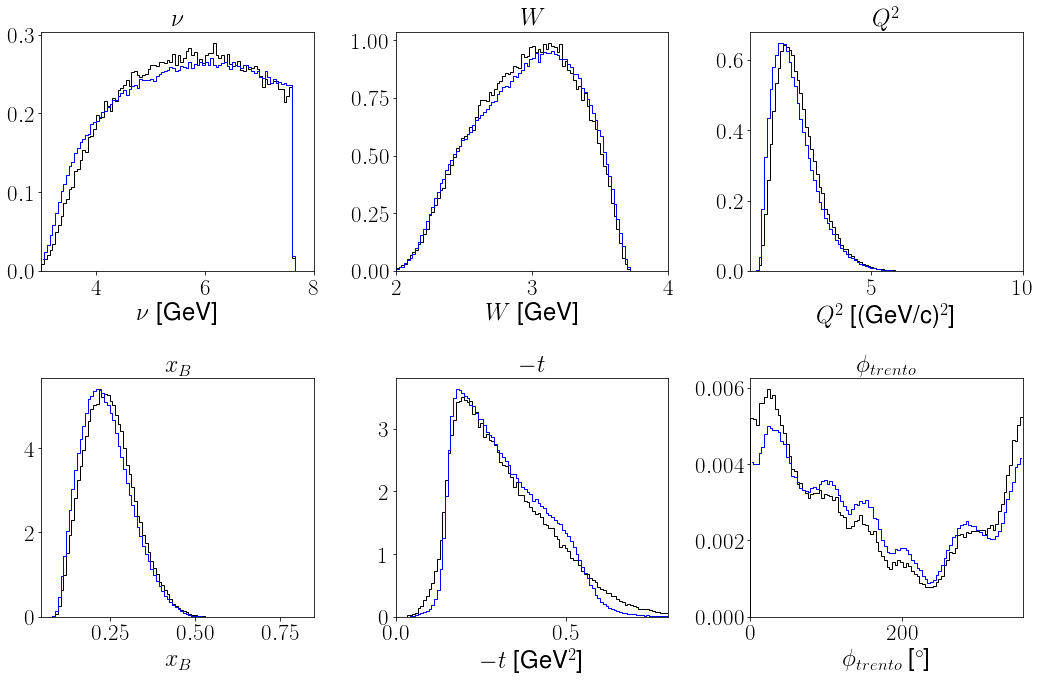

<Figure size 432x288 with 0 Axes>

In [26]:
varstoplot = ["nu", "W", "Q2", "xB", "t2", "phi2"]
title = [r"$\nu$", r"$W$", r"$Q^{2}$", r"$x_{B}$", r"$-t$", r"$\phi_{trento}$" ]
unit = [GeV, GeV, GeVc2, None, GeV2, degree, GeV2, degree]
binstarts = [3, 2, 1, 0.05, 0, 0]
binends = [8, 4, 10, 0.85, 0.8, 360]
fig, axs = plt.subplots(2, 3, figsize = (15, 10))
for xind in range(0,3):
    for yind in range(0, 2):
        ind =xind+3*yind
        start = binstarts[ind]
        end = binends[ind]
        bins = np.linspace(start, end, 101)
        simDist_dvpi0, bins = np.histogram(bkgSimInbCD[varstoplot[ind]], bins, density = True)
        simDist_dvcs, bins = np.histogram(dvcsSimInbCD[varstoplot[ind]], bins, density = True)
#         simDist = len_pi0ExpInbCD/len_pi0SimInbCD*simDist_dvpi0 + (len_epgExpInbCD/len_dvcsSimInbCD-len_bkgSimInbCD/len_pi0SimInbCD*len_pi0ExpInbCD/len_dvcsSimInbCD)*simDist_dvcs
        simDist = (1-contCD)*simDist_dvcs + contCD*simDist_dvpi0
        expDist, bins = np.histogram(epgExpInbCD[varstoplot[ind]], bins, density=True)
        bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
        axs[yind, xind].step(bincenters, simDist, where='mid',color='b', linewidth=1)
#         axs[yind, xind].step(bincenters, contCD*simDist_dvpi0, where='mid',color='g', linewidth=1)
#         axs[yind, xind].step(bincenters, (1/len_dvcsSimInbCD-cont_inb_CD/len_dvcsSimInbCD)*len_epgExpInbCD*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].hist(epgExpInbCD[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', density=True, linewidth=1)
#         axs[yind, xind].hist(epgExpInbCD[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', linewidth=1)
#         axs[yind, xind].step(bincenters, expDist - len_pi0ExpInbCD/len_pi0SimInbCD*simDist_dvpi0, where='mid',color='k', linewidth=1)
        print(varstoplot[ind], nphistmean(expDist - len(pi0ExpInbCD)/len(pi0SimInbCD)*simDist_dvpi0, bins))
#         axs[yind, xind].step(bincenters, (1-contCD)*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].set_title(title[ind])
        axs[yind, xind].set_xlim([start, end])
        if (unit[ind]):
            axs[yind, xind].set_xlabel(title[ind]+" [" + unit[ind] +"]")
        else:
            axs[yind, xind].set_xlabel(title[ind])
# axs[0,2].set_xticks([2.2, 2.7, 3.2])
# axs[1,0].set_xticks([0.29, 0.32, 0.35, 0.38])
# axs[1,1].set_xticks([0.23, 0.3, 0.39, 0.52])
# axs[1,2].set_xticks([0, 90, 180, 270, 360])
plt.tight_layout()
# plt.savefig("kineCD.pdf")
# plt.savefig("analysisnote/inbending1.pdf")
plt.show()
plt.clf()

coneAngle 23.06700916501025
reconGam 0.6174913101875932
coplanarity 2.900504746580837
ME_epg 0.2715815089099359
MM2_epg -0.001485617011184417
MM2_eg 1.0486071445509806
MM2_ep -0.015134591646636017
MPt 0.0549658751688064


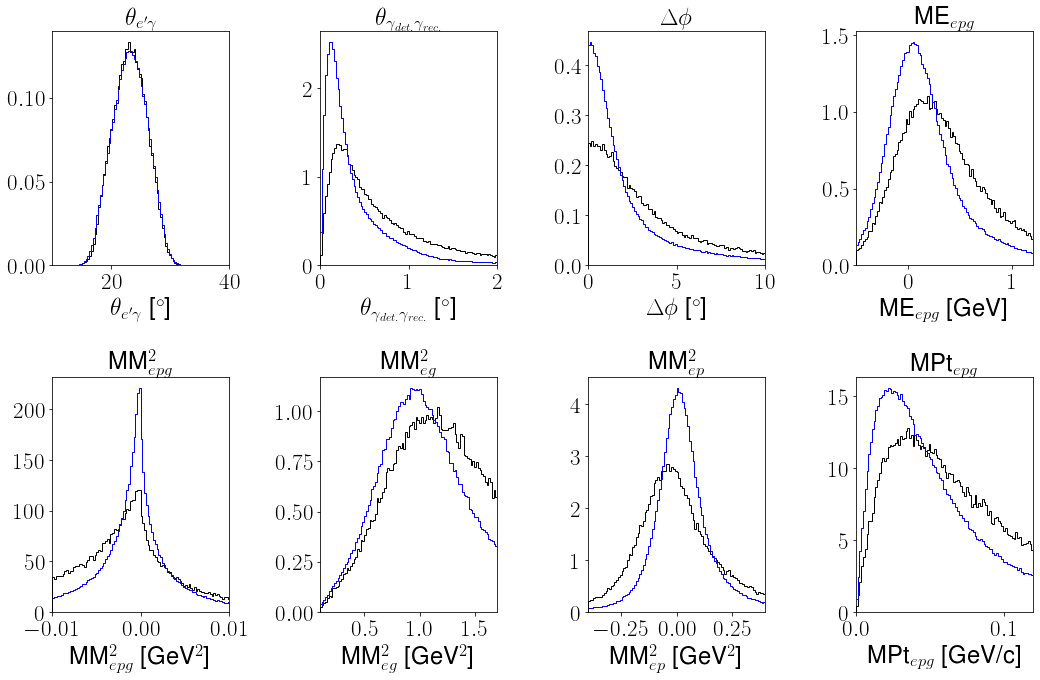

<Figure size 432x288 with 0 Axes>

In [279]:
varstoplot = ["coneAngle", "reconGam", "coplanarity", "ME_epg", "MM2_epg", "MM2_eg", "MM2_ep", "MPt"]
title = [r"$\theta_{e'\gamma}$", r"$\theta_{\gamma_{det.}\gamma_{rec.}}$", r"$\Delta\phi$" , "ME"+r"${}_{epg}$", "MM"+r"${}^{2}_{epg}$", "MM"+r"${}^{2}_{eg}$", "MM"+r"${}^{2}_{ep}$", "MPt"+r"${}_{epg}$"]
unit = [degree, degree, degree, GeV, GeV2, GeV2, GeV2, GeVc]
binstarts = [10, 0, 0, -0.5, -0.01, 0.1,-0.4 , 0]
binends = [40, 2, 10, 1.2, 0.01, 1.7, 0.4, 0.12]
fig, axs = plt.subplots(2, 4, figsize = (15,10))
for yind in range(0, 2):
    for xind in range(0,4):
        ind = 4*yind + xind
        start = binstarts[ind]
        end = binends[ind]
        bins = np.linspace(start, end, 101)
        simDist_dvpi0, bins = np.histogram(bkgSimInbCD[varstoplot[ind]], bins, density = True)
        simDist_dvcs, bins = np.histogram(dvcsSimInbCD[varstoplot[ind]], bins, density = True)
#         simDist = len_pi0ExpInbCD/len_pi0SimInbCD*simDist_dvpi0 + (len_epgExpInbCD/len_dvcsSimInbCD-len_bkgSimInbCD/len_pi0SimInbCD*len_pi0ExpInbCD/len_dvcsSimInbCD)*simDist_dvcs
        simDist = (1-contCD)*simDist_dvcs + contCD*simDist_dvpi0
        expDist, bins = np.histogram(epgExpInbCD[varstoplot[ind]], bins, density=True)
        bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
        axs[yind, xind].step(bincenters, simDist, where='mid',color='b', linewidth=1)
#         axs[yind, xind].step(bincenters, c*simDist_dvpi0, where='mid',color='g', linewidth=1)
#         axs[yind, xind].step(bincenters, (1/len_dvcsSimInbCD-cont_inb_CD/len_dvcsSimInbCD)*len_epgExpInbCD*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].hist(epgExpInbCD[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', density=True, linewidth=1)
#         axs[yind, xind].hist(epgExpInbCD[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', linewidth=1)
#         axs[yind, xind].step(bincenters, expDist - len_pi0ExpInbCD/len_pi0SimInbCD*simDist_dvpi0, where='mid',color='k', linewidth=1)
        print(varstoplot[ind], nphistmean(expDist - len(pi0ExpInbCD)/len(pi0SimInbCD)*simDist_dvpi0, bins))
#         axs[yind, xind].step(bincenters, (1-c)*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].set_title(title[ind])
        axs[yind, xind].set_xlim([start, end])
        if (unit[ind]):
            axs[yind, xind].set_xlabel(title[ind]+" [" + unit[ind] +"]")
        else:
            axs[yind, xind].set_xlabel(title[ind])
# axs[0,2].set_xticks([2.2, 2.7, 3.2])
# axs[1,0].set_xticks([0.29, 0.32, 0.35, 0.38])
# axs[1,1].set_xticks([0.23, 0.3, 0.39, 0.52])
# axs[1,2].set_xticks([0, 90, 180, 270, 360])
plt.tight_layout()
# plt.savefig("kineCD.pdf")
# plt.savefig("analysisnote/inbending1.pdf")
plt.show()
plt.clf()

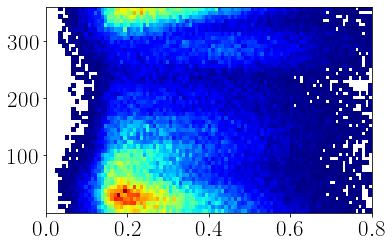

In [262]:
plt.hist2d(epgExpInbCD.t2, epgExpInbCD.phi2, bins = [np.linspace(0, 0.8, 101),51], cmap = cmap, cmin = 1)
plt.show()

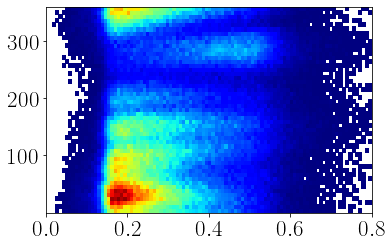

In [263]:
plt.hist2d(dvcsSimInbCD.t2, dvcsSimInbCD.phi2, bins = [np.linspace(0, 0.8, 101),51], cmap = cmap, cmin = 1)
plt.show()

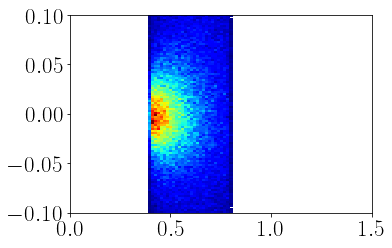

In [265]:
plt.hist2d(epgExpInbCD.Pp, epgExpInbCD.t2-epgExpInbCD.t1, bins = [np.linspace(0, 1.5, 101),np.linspace(-0.1, 0.1, 101)], cmap = cmap, cmin = 1)
plt.show()

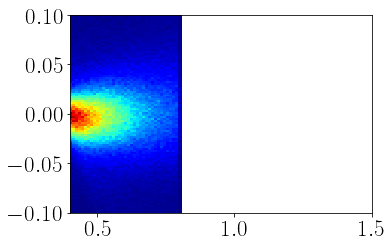

In [266]:
plt.hist2d(dvcsSimInbCD.Pp, dvcsSimInbCD.t2-dvcsSimInbCD.t1, bins = [np.linspace(0.4, 1.5, 101),np.linspace(-0.1, 0.1, 101)], cmap = cmap, cmin = 1)
plt.show()

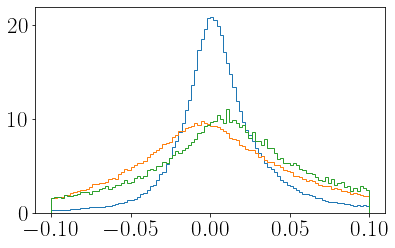

In [229]:
plt.hist(dvcsSimInbFD.t2-dvcsSimInbFD.t1, bins = np.linspace(-0.1, 0.1, 101), density = True, histtype = 'step')
plt.hist(bkgSimInbFD.t2-bkgSimInbFD.t1, bins = np.linspace(-0.1, 0.1, 101), density = True, histtype = 'step')
plt.hist(epgExpInbFD.t2-epgExpInbFD.t1, bins = np.linspace(-0.1, 0.1, 101), density = True, histtype = 'step')
plt.show()

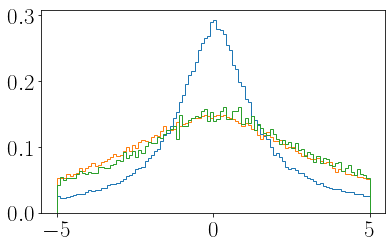

In [230]:
plt.hist(dvcsSimInbFD.phi2-dvcsSimInbFD.phi1, bins = np.linspace(-5, 5, 101), density = True, histtype = 'step')
plt.hist(bkgSimInbFD.phi2-bkgSimInbFD.phi1, bins = np.linspace(-5, 5, 101), density = True, histtype = 'step')
plt.hist(epgExpInbFD.phi2-epgExpInbFD.phi1, bins = np.linspace(-5, 5, 101), density = True, histtype = 'step')
plt.show()

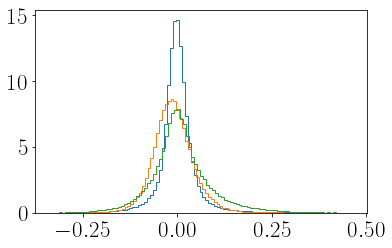

In [137]:
plt.hist(dvcsSimInbCD.t2-dvcsSimInbCD.t1, bins = 101, density = True, histtype = 'step')
plt.hist(bkgSimInbCD.t2-bkgSimInbCD.t1, bins = 101, density = True, histtype = 'step')
plt.hist(epgExpInbCD.t2-epgExpInbCD.t1, bins = 101, density = True, histtype = 'step')
plt.show()

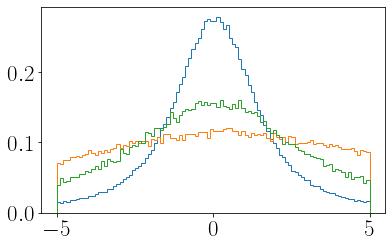

In [268]:
plt.hist(dvcsSimInbCD.phi2-dvcsSimInbCD.phi1, bins = np.linspace(-5, 5, 101), density = True, histtype = 'step')
plt.hist(bkgSimInbCD.phi2-bkgSimInbCD.phi1, bins = np.linspace(-5, 5, 101), density = True, histtype = 'step')
plt.hist(epgExpInbCD.phi2-epgExpInbCD.phi1, bins = np.linspace(-5, 5, 101), density = True, histtype = 'step')
plt.show()

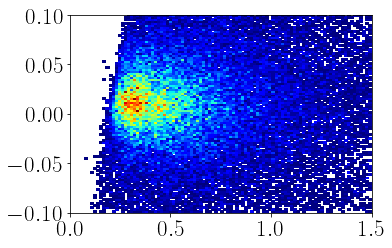

In [121]:
plt.hist2d(epgExpInbFD.t2, epgExpInbFD.t2-epgExpInbFD.t1, bins = [np.linspace(0, 1.5, 101),np.linspace(-0.1, 0.1, 101)], cmap = cmap, cmin = 1)
plt.show()

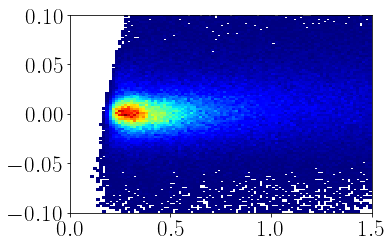

In [119]:
plt.hist2d(dvcsSimInbFD.t2, dvcsSimInbFD.t2-dvcsSimInbFD.t1, bins = [np.linspace(0, 1.5, 101),np.linspace(-0.1, 0.1, 101)], cmap = cmap, cmin = 1)
plt.show()

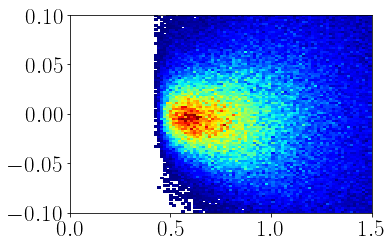

In [216]:
plt.hist2d(bkgSimInbFD.Pp, bkgSimInbFD.t2-bkgSimInbFD.t1, bins = [np.linspace(0, 1.5, 101),np.linspace(-0.1, 0.1, 101)], cmap = cmap, cmin = 1)
plt.show()

In [197]:
gen_bin1_3063 = np.array([3377, 3191, 3057, 2928, 2743, 2490, 2250, 2156, 1963, 1966, 2063,
       2069, 2202, 2207, 2522, 2639, 2949, 3258, 3245, 3354])
gen_bin1_3066 = np.array([3322, 3262, 3142, 2948, 2686, 2485, 2348, 2194, 2032, 1961, 2003,
       2115, 2162, 2312, 2428, 2681, 2936, 3148, 3233, 3307])
gen_bin1_3067 = np.array([3353, 3194, 3131, 2994, 2777, 2453, 2281, 2093, 2059, 1961, 1938,
       2033, 2170, 2285, 2515, 2713, 2924, 3194, 3299, 3284])
gen_bin1_3073 = np.array([3226, 3369, 3113, 2923, 2733, 2534, 2259, 2084, 2007, 2021, 2053,
       2127, 2148, 2306, 2486, 2691, 2974, 3230, 3216, 3245])


In [348]:
gen_bin1 = (gen_bin1_3063 + gen_bin1_3066 + gen_bin1_3067 + gen_bin1_3073)
bhFD_bin1 = [ 0.03845, 0.03517, 0.03065, 0.02576, 0.02115, 0.01714, 0.01385, 0.01122, 0.00917, 0.00758, 0.00636, 0.00543, 0.00473, 0.00421, 0.00384, 0.00359, 0.00345, 0.00340, 0.00345, 0.00359, 0.00384, 0.00421, 0.00473, 0.00543, 0.00636, 0.00758, 0.00917, 0.01122, 0.01385, 0.01714, 0.02115, 0.02576, 0.03065, 0.03517, 0.03845, 0.03965]
dvcsFD_bin1 = [ 0.03051, 0.03063, 0.03067, 0.03047, 0.02998, 0.02923, 0.02827, 0.02719, 0.02607, 0.02496, 0.02392, 0.02297, 0.02213, 0.02143, 0.02088, 0.02048, 0.02024, 0.02016, 0.02024, 0.02048, 0.02088, 0.02143, 0.02213, 0.02297, 0.02392, 0.02496, 0.02607, 0.02719, 0.02827, 0.02923, 0.02998, 0.03047, 0.03067, 0.03063, 0.03051, 0.03045]
bhCD_bin1 = [0.04873, 0.04438, 0.03843, 0.03208, 0.02617, 0.02110, 0.01697, 0.01370, 0.01116, 0.00921, 0.00772, 0.00659, 0.00574, 0.00512, 0.00466, 0.00436, 0.00419, 0.00413, 0.00419, 0.00436, 0.00466, 0.00512, 0.00574, 0.00659, 0.00772, 0.00921, 0.01116, 0.01370, 0.01697, 0.02110, 0.02617, 0.03208, 0.03843, 0.04438, 0.04873, 0.05034]
dvcsCD_bin1 = [ 0.03830, 0.03793, 0.03725, 0.03627, 0.03503, 0.03359, 0.03206, 0.03050, 0.02900, 0.02759, 0.02630, 0.02516, 0.02419, 0.02338, 0.02275, 0.02229, 0.02202, 0.02193, 0.02202, 0.02229, 0.02275, 0.02338, 0.02419, 0.02516, 0.02630, 0.02759, 0.02900, 0.03050, 0.03206, 0.03359, 0.03503, 0.03627, 0.03725, 0.03793, 0.03830, 0.03842]
# dvcsCD_bin1 = [0.06358, 0.05786, 0.05008, 0.04184, 0.03424, 0.02780, 0.02262, 0.01857, 0.01548, 0.01312, 0.01134, 0.01001, 0.00900, 0.00826, 0.00774, 0.00738, 0.00718, 0.00711, 0.00718, 0.00738, 0.00774, 0.00826, 0.00900, 0.01001, 0.01134, 0.01312, 0.01548, 0.01857, 0.02262, 0.02780, 0.03424, 0.04184, 0.05008, 0.05786, 0.06358, 0.06571]

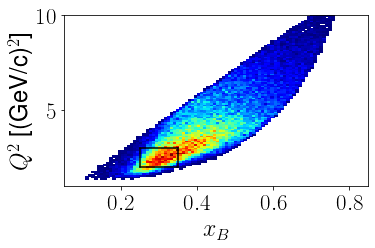

In [157]:
plt.hist2d(epgExpInbFD.xB, epgExpInbFD.Q2, bins = [np.linspace(0.05, 0.85, 101), np.linspace(1, 10, 101)], cmin = 1, cmap  = cmap)
plt.plot(np.linspace(0.25, 0.35, 101), np.linspace(2, 2 , 101), color = 'k')
plt.plot(np.linspace(0.25, 0.35, 101), np.linspace(3, 3 , 101), color = 'k')
plt.plot(np.linspace(0.25, 0.25, 101), np.linspace(2, 3 , 101), color = 'k')
plt.plot(np.linspace(0.35, 0.35, 101), np.linspace(2, 3 , 101), color = 'k')
plt.xlabel(r"$x_B$")
plt.ylabel(r"$Q^2$"+" ["+GeVc2+"]")
plt.show()

In [266]:
#bin1 0.25<xB<0.35, 2 < Q^2 < 3, 0 < -t < 0.5
epgExpInbFD_bin1 = dfinOneBin(epgExpInbFD, 0.25, 0.35, 2, 3, 0, 0.5, -0.1, 360.1)
pi0ExpInbFD_bin1 = dfinOneBin(pi0ExpInbFD, 0.25, 0.35, 2, 3, 0, 0.5, -0.1, 360.1)
dvcsSimInbFD_bin1 = dfinOneBin(dvcsSimInbFD, 0.25, 0.35, 2, 3, 0, 0.5, -0.1, 360.1)
bkgSimInbFD_bin1 = dfinOneBin(bkgSimInbFD, 0.25, 0.35, 2, 3, 0, 0.5, -0.1, 360.1)
pi0SimInbFD_bin1 = dfinOneBin(pi0SimInbFD, 0.25, 0.35, 2, 3, 0, 0.5, -0.1, 360.1)

#bin1 0.25<xB<0.35, 2 < Q^2 < 3, 0 < -t < 0.5
epgExpInbCD_bin1 = dfinOneBin(epgExpInbCD, 0.25, 0.35, 2, 3, 0, 0.5, -0.1, 360.1)
pi0ExpInbCD_bin1 = dfinOneBin(pi0ExpInbCD, 0.25, 0.35, 2, 3, 0, 0.5, -0.1, 360.1)
dvcsSimInbCD_bin1 = dfinOneBin(dvcsSimInbCD, 0.25, 0.35, 2, 3, 0, 0.5, -0.1, 360.1)
bkgSimInbCD_bin1 = dfinOneBin(bkgSimInbCD, 0.25, 0.35, 2, 3, 0, 0.5, -0.1, 360.1)
pi0SimInbCD_bin1 = dfinOneBin(pi0SimInbCD, 0.25, 0.35, 2, 3, 0, 0.5, -0.1, 360.1)


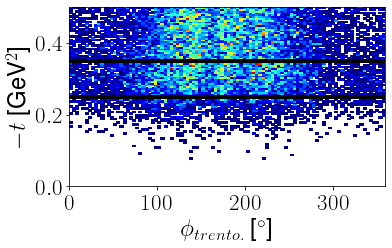

In [268]:
plt.hist2d(epgExpInbFD.phi2, epgExpInbFD.t2, bins = [np.linspace(0.0, 360, 101), np.linspace(0, 0.5, 101)], cmin = 1, cmap  = cmap)
plt.plot(np.linspace(0, 360, 101), np.linspace(0.35, 0.35, 101), color = 'k', linewidth = 4)
plt.plot(np.linspace(0, 360, 101), np.linspace(0.25, 0.25, 101), color = 'k', linewidth = 4)
# plt.plot(np.linspace(0.25, 0.25, 101), np.linspace(0, 360 , 101), color = 'k')
# plt.plot(np.linspace(0.35, 0.35, 101), np.linspace(0, 360 , 101), color = 'k')
plt.xlabel(r"$\phi_{trento.}$" +" [" + degree+"]")
plt.ylabel(r"$-t$" +" [" + GeV2+"]")
plt.show()

In [218]:
#bin1 0.25<xB<0.35, 2 < Q^2 < 3, 0.25 < -t < 0.35
epgExpInbFD_bin1 = dfinOneBin(epgExpInbFD, 0.25, 0.35, 2, 3, 0.25, 0.35, -0.1, 360.1)
pi0ExpInbFD_bin1 = dfinOneBin(pi0ExpInbFD, 0.25, 0.35, 2, 3, 0.25, 0.35, -0.1, 360.1)
dvcsSimInbFD_bin1 = dfinOneBin(dvcsSimInbFD, 0.25, 0.35, 2, 3, 0.25, 0.35, -0.1, 360.1)
bkgSimInbFD_bin1 = dfinOneBin(bkgSimInbFD, 0.25, 0.35, 2, 3, 0.25, 0.35, -0.1, 360.1)
pi0SimInbFD_bin1 = dfinOneBin(pi0SimInbFD, 0.25, 0.35, 2, 3, 0.25, 0.35, -0.1, 360.1)

#bin1 0.25<xB<0.35, 2 < Q^2 < 3, 0.25 < -t < 0.35
epgExpInbCD_bin1 = dfinOneBin(epgExpInbCD, 0.25, 0.35, 2, 3, 0.25, 0.35, -0.1, 360.1)
pi0ExpInbCD_bin1 = dfinOneBin(pi0ExpInbCD, 0.25, 0.35, 2, 3, 0.25, 0.35, -0.1, 360.1)
dvcsSimInbCD_bin1 = dfinOneBin(dvcsSimInbCD, 0.25, 0.35, 2, 3, 0.25, 0.35, -0.1, 360.1)
bkgSimInbCD_bin1 = dfinOneBin(bkgSimInbCD, 0.25, 0.35, 2, 3, 0.25, 0.35, -0.1, 360.1)
pi0SimInbCD_bin1 = dfinOneBin(pi0SimInbCD, 0.25, 0.35, 2, 3, 0.25, 0.35, -0.1, 360.1)

In [219]:
contCD = len(pi0ExpInbCD)*len(bkgSimInbCD)/len(pi0SimInbCD)/len(epgExpInbCD)
contFD = len(pi0ExpInbFD)*len(bkgSimInbFD)/len(pi0SimInbFD)/len(epgExpInbFD)
print(contFD, contCD)

0.43188115199359634 0.18266904199111794


In [220]:
contCD_bin1 = len(pi0ExpInbCD_bin1)*len(bkgSimInbCD_bin1)/len(pi0SimInbCD_bin1)/len(epgExpInbCD_bin1)
contFD_bin1 = len(pi0ExpInbFD_bin1)*len(bkgSimInbFD_bin1)/len(pi0SimInbFD_bin1)/len(epgExpInbFD_bin1)
print(contFD_bin1, contCD_bin1)

0.34236808054491075 0.25076736084097345


In [184]:
for i in binscenters*np.pi/180:
    print("./dvcsgen --x 0.303850538445024 0.303850538445024 --q2 2.484677726825357 2.484677726825357 --t 0.3010315491978143 0.3010315491978143 --bh 3 --gpd 101 --vv2cut 0.6 --delta 0.1 --printrad --phi {}| grep averaged".format(i))

./dvcsgen --x 0.303850538445024 0.303850538445024 --q2 2.484677726825357 2.484677726825357 --t 0.3010315491978143 0.3010315491978143 --bh 3 --gpd 101 --vv2cut 0.6 --delta 0.1 --printrad --phi 0.15707963267948966| grep averaged
./dvcsgen --x 0.303850538445024 0.303850538445024 --q2 2.484677726825357 2.484677726825357 --t 0.3010315491978143 0.3010315491978143 --bh 3 --gpd 101 --vv2cut 0.6 --delta 0.1 --printrad --phi 0.47123889803846897| grep averaged
./dvcsgen --x 0.303850538445024 0.303850538445024 --q2 2.484677726825357 2.484677726825357 --t 0.3010315491978143 0.3010315491978143 --bh 3 --gpd 101 --vv2cut 0.6 --delta 0.1 --printrad --phi 0.7853981633974483| grep averaged
./dvcsgen --x 0.303850538445024 0.303850538445024 --q2 2.484677726825357 2.484677726825357 --t 0.3010315491978143 0.3010315491978143 --bh 3 --gpd 101 --vv2cut 0.6 --delta 0.1 --printrad --phi 1.0995574287564276| grep averaged
./dvcsgen --x 0.303850538445024 0.303850538445024 --q2 2.484677726825357 2.484677726825357 --t

In [2]:
varstoplot = ["nu", "W", "Q2", "xB", "t2", "phi2"]
title = [r"$\nu$", r"$W$", r"$Q^{2}$", r"$x_{B}$", r"$-t$", r"$\phi_{trento}$" ]
unit = [GeV, GeV, GeVc2, None, GeV2, degree, GeV2, degree]
binstarts = [3, 2, 2, 0.25, 0.25, 0]
binends = [6.5, 3.1, 3, 0.35, 0.35, 360]
fig, axs = plt.subplots(2, 3, figsize = (15, 10))
for xind in range(0,3):
    for yind in range(0, 2):
        ind =xind+3*yind
        start = binstarts[ind]
        end = binends[ind]
        bins = np.linspace(start, end, 101)
        simDist_dvpi0, bins = np.histogram(bkgSimInbFD_bin1[varstoplot[ind]], bins, density = True)
        simDist_dvcs, bins = np.histogram(dvcsSimInbFD_bin1[varstoplot[ind]], bins, density = True)
#         simDist = len_pi0ExpInbFD_bin1/len_pi0SimInbFD_bin1*simDist_dvpi0 + (len_epgExpInbFD_bin1/len_dvcsSimInbFD_bin1-len_bkgSimInbFD_bin1/len_pi0SimInbFD_bin1*len_pi0ExpInbFD_bin1/len_dvcsSimInbFD_bin1)*simDist_dvcs
        simDist = (1-contFD_bin1)*simDist_dvcs + contFD_bin1*simDist_dvpi0
        expDist, bins = np.histogram(epgExpInbFD_bin1[varstoplot[ind]], bins, density=True)
        bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
        axs[yind, xind].step(bincenters, simDist, where='mid',color='b', linewidth=1)
#         axs[yind, xind].step(bincenters, c*simDist_dvpi0, where='mid',color='g', linewidth=1)
#         axs[yind, xind].step(bincenters, (1/len_dvcsSimInbFD_bin1-cont_inb_FD_bin1/len_dvcsSimInbFD_bin1)*len_epgExpInbFD_bin1*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].hist(epgExpInbFD_bin1[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', density=True, linewidth=1)
#         axs[yind, xind].hist(epgExpInbFD_bin1[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', linewidth=1)
#         axs[yind, xind].step(bincenters, expDist - len_pi0ExpInbFD_bin1/len_pi0SimInbFD_bin1*simDist_dvpi0, where='mid',color='k', linewidth=1)
        print(varstoplot[ind], nphistmean(expDist - len(pi0ExpInbFD_bin1)/len(pi0SimInbFD_bin1)*simDist_dvpi0, bins))
#         axs[yind, xind].step(bincenters, (1-c)*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].set_title(title[ind])
        axs[yind, xind].set_xlim([start, end])
        if (unit[ind]):
            axs[yind, xind].set_xlabel(title[ind]+" [" + unit[ind] +"]")
        else:
            axs[yind, xind].set_xlabel(title[ind])
# axs[0,2].set_xticks([2.2, 2.7, 3.2])
# axs[1,0].set_xticks([0.29, 0.32, 0.35, 0.38])
# axs[1,1].set_xticks([0.23, 0.3, 0.39, 0.52])
# axs[1,2].set_xticks([0, 90, 180, 270, 360])
plt.tight_layout()
# plt.savefig("kineFD_bin1.pdf")
# plt.savefig("analysisnote/inbending1.pdf")
plt.show()
plt.clf()

NameError: name 'GeV' is not defined

In [185]:
Frad = np.array([0.92935044155213331, 0.93121964470636276, 0.93136621700437272, 0.92849306525278452, 0.92355014915619338, 0.91795402422083228, 0.91277473176827484, 0.90877887197272933, 0.90575293644335408, 0.90425775773647876, 0.90437314619244424, 0.90569884439923387, 0.90863900753744009, 0.91283724879330086, 0.91794641678852307, 0.92358289756192502, 0.92837640622568718, 0.93126563596358514, 0.93115467233585636, 0.92924221833186493])

coneAngle 30.827279480945734
reconGam 0.7753286507333721
coplanarity 3.516709319983654
ME_epg 0.2290226360492291
MM2_epg -0.001067295533021219
MM2_eg 1.0930468385455383
MM2_ep 0.03196646055338601
MPt 0.061614376129350217


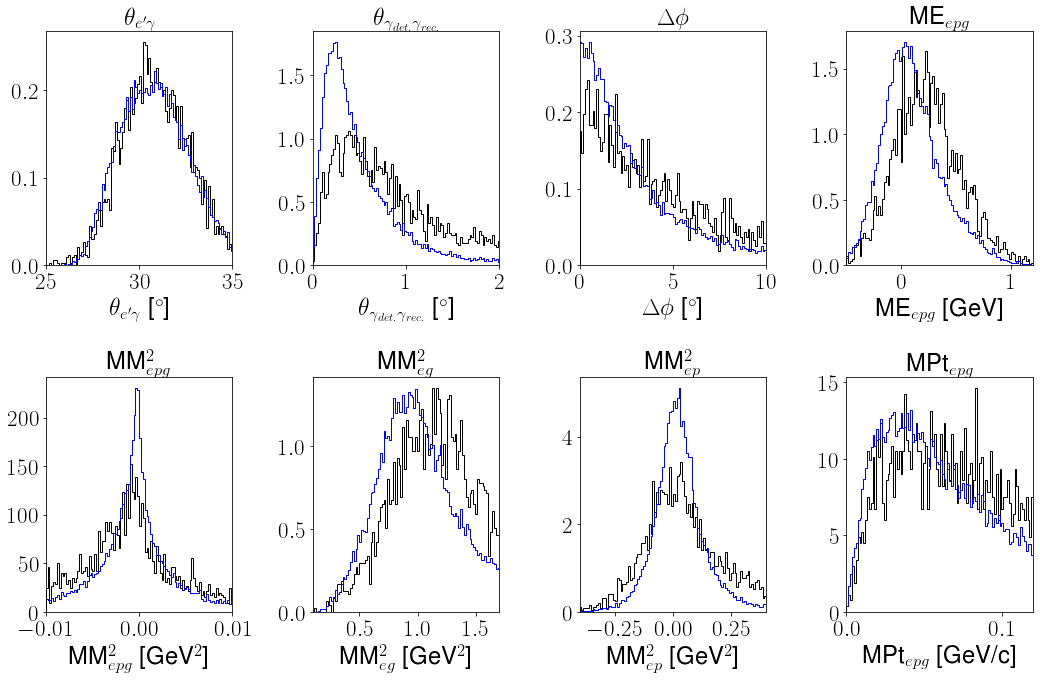

<Figure size 432x288 with 0 Axes>

In [274]:
varstoplot = ["coneAngle", "reconGam", "coplanarity", "ME_epg", "MM2_epg", "MM2_eg", "MM2_ep", "MPt"]
title = [r"$\theta_{e'\gamma}$", r"$\theta_{\gamma_{det.}\gamma_{rec.}}$", r"$\Delta\phi$" , "ME"+r"${}_{epg}$", "MM"+r"${}^{2}_{epg}$", "MM"+r"${}^{2}_{eg}$", "MM"+r"${}^{2}_{ep}$", "MPt"+r"${}_{epg}$"]
unit = [degree, degree, degree, GeV, GeV2, GeV2, GeV2, GeVc]
binstarts = [25, 0, 0, -0.5, -0.01, 0.1,-0.4 , 0]
binends = [35, 2, 10, 1.2, 0.01, 1.7, 0.4, 0.12]
fig, axs = plt.subplots(2, 4, figsize = (15,10))
for yind in range(0, 2):
    for xind in range(0,4):
        ind = 4*yind + xind
        start = binstarts[ind]
        end = binends[ind]
        bins = np.linspace(start, end, 101)
        simDist_dvpi0, bins = np.histogram(bkgSimInbFD_bin1[varstoplot[ind]], bins, density = True)
        simDist_dvcs, bins = np.histogram(dvcsSimInbFD_bin1[varstoplot[ind]], bins, density = True)
#         simDist = len_pi0ExpInbFD_bin1/len_pi0SimInbFD_bin1*simDist_dvpi0 + (len_epgExpInbFD_bin1/len_dvcsSimInbFD_bin1-len_bkgSimInbFD_bin1/len_pi0SimInbFD_bin1*len_pi0ExpInbFD_bin1/len_dvcsSimInbFD_bin1)*simDist_dvcs
        simDist = (1-contFD_bin1)*simDist_dvcs + contFD_bin1*simDist_dvpi0
        expDist, bins = np.histogram(epgExpInbFD_bin1[varstoplot[ind]], bins, density=True)
        bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
        axs[yind, xind].step(bincenters, simDist, where='mid',color='b', linewidth=1)
#         axs[yind, xind].step(bincenters, c*simDist_dvpi0, where='mid',color='g', linewidth=1)
#         axs[yind, xind].step(bincenters, (1/len_dvcsSimInbFD_bin1-cont_inb_FD_bin1/len_dvcsSimInbFD_bin1)*len_epgExpInbFD_bin1*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].hist(epgExpInbFD_bin1[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', density=True, linewidth=1)
#         axs[yind, xind].hist(epgExpInbFD_bin1[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', linewidth=1)
#         axs[yind, xind].step(bincenters, expDist - len_pi0ExpInbFD_bin1/len_pi0SimInbFD_bin1*simDist_dvpi0, where='mid',color='k', linewidth=1)
        print(varstoplot[ind], nphistmean(expDist - len(pi0ExpInbFD_bin1)/len(pi0SimInbFD_bin1)*simDist_dvpi0, bins))
#         axs[yind, xind].step(bincenters, (1-c)*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].set_title(title[ind])
        axs[yind, xind].set_xlim([start, end])
        if (unit[ind]):
            axs[yind, xind].set_xlabel(title[ind]+" [" + unit[ind] +"]")
        else:
            axs[yind, xind].set_xlabel(title[ind])
# axs[0,2].set_xticks([2.2, 2.7, 3.2])
# axs[1,0].set_xticks([0.29, 0.32, 0.35, 0.38])
# axs[1,1].set_xticks([0.23, 0.3, 0.39, 0.52])
# axs[1,2].set_xticks([0, 90, 180, 270, 360])
plt.tight_layout()
# plt.savefig("kineFD_bin1.pdf")
# plt.savefig("analysisnote/inbending1.pdf")
plt.show()
plt.clf()

nu 4.675845707790095
xB 0.28847136630673964
W 2.6644770348260574
t2 0.296016681866769
Q2 2.5116790919053558
phi2 149.98046760558995


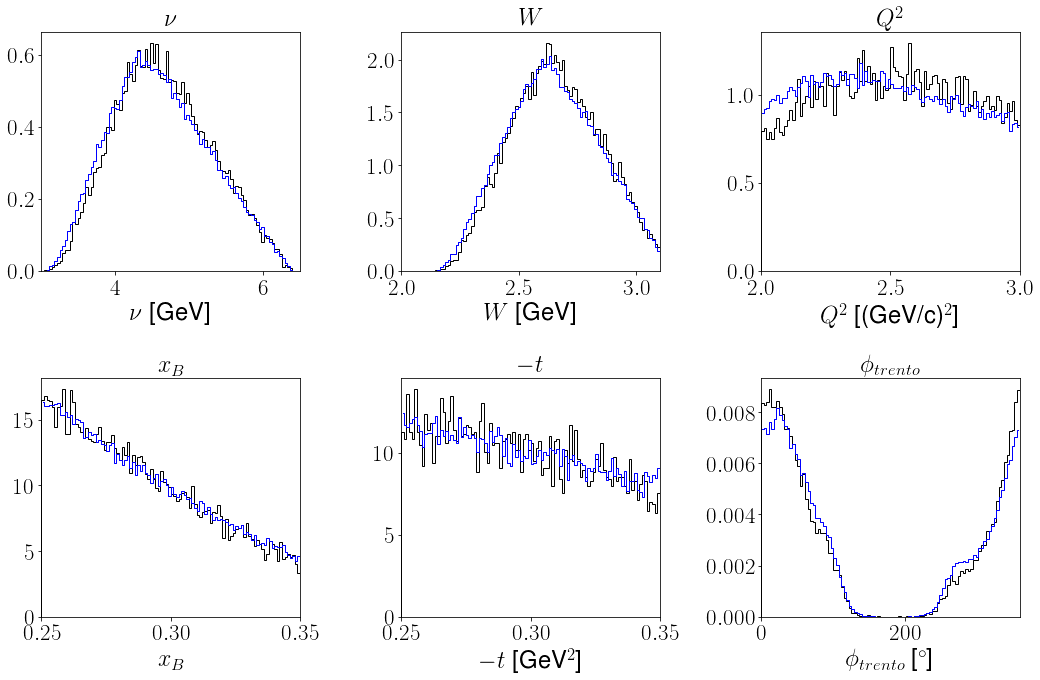

<Figure size 432x288 with 0 Axes>

In [278]:
varstoplot = ["nu", "W", "Q2", "xB", "t2", "phi2"]
title = [r"$\nu$", r"$W$", r"$Q^{2}$", r"$x_{B}$", r"$-t$", r"$\phi_{trento}$" ]
unit = [GeV, GeV, GeVc2, None, GeV2, degree, GeV2, degree]
binstarts = [3, 2, 2, 0.25, 0.25, 0]
binends = [6.5, 3.1, 3, 0.35, 0.35, 360]
fig, axs = plt.subplots(2, 3, figsize = (15, 10))
for xind in range(0,3):
    for yind in range(0, 2):
        ind =xind+3*yind
        start = binstarts[ind]
        end = binends[ind]
        bins = np.linspace(start, end, 101)
        simDist_dvpi0, bins = np.histogram(bkgSimInbCD_bin1[varstoplot[ind]], bins, density = True)
        simDist_dvcs, bins = np.histogram(dvcsSimInbCD_bin1[varstoplot[ind]], bins, density = True)
#         simDist = len_pi0ExpInbCD_bin1/len_pi0SimInbCD_bin1*simDist_dvpi0 + (len_epgExpInbCD_bin1/len_dvcsSimInbCD_bin1-len_bkgSimInbCD_bin1/len_pi0SimInbCD_bin1*len_pi0ExpInbCD_bin1/len_dvcsSimInbCD_bin1)*simDist_dvcs
        simDist = (1-contCD_bin1)*simDist_dvcs + contCD_bin1*simDist_dvpi0
        expDist, bins = np.histogram(epgExpInbCD_bin1[varstoplot[ind]], bins, density=True)
        bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
        axs[yind, xind].step(bincenters, simDist, where='mid',color='b', linewidth=1)
#         axs[yind, xind].step(bincenters, c*simDist_dvpi0, where='mid',color='g', linewidth=1)
#         axs[yind, xind].step(bincenters, (1/len_dvcsSimInbCD_bin1-cont_inb_CD_bin1/len_dvcsSimInbCD_bin1)*len_epgExpInbCD_bin1*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].hist(epgExpInbCD_bin1[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', density=True, linewidth=1)
#         axs[yind, xind].hist(epgExpInbCD_bin1[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', linewidth=1)
#         axs[yind, xind].step(bincenters, expDist - len_pi0ExpInbCD_bin1/len_pi0SimInbCD_bin1*simDist_dvpi0, where='mid',color='k', linewidth=1)
        print(varstoplot[ind], nphistmean(expDist - len(pi0ExpInbCD_bin1)/len(pi0SimInbCD_bin1)*simDist_dvpi0, bins))
#         axs[yind, xind].step(bincenters, (1-c)*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].set_title(title[ind])
        axs[yind, xind].set_xlim([start, end])
        if (unit[ind]):
            axs[yind, xind].set_xlabel(title[ind]+" [" + unit[ind] +"]")
        else:
            axs[yind, xind].set_xlabel(title[ind])
# axs[0,2].set_xticks([2.2, 2.7, 3.2])
# axs[1,0].set_xticks([0.29, 0.32, 0.35, 0.38])
# axs[1,1].set_xticks([0.23, 0.3, 0.39, 0.52])
# axs[1,2].set_xticks([0, 90, 180, 270, 360])
plt.tight_layout()
# plt.savefig("kineCD_bin1.pdf")
# plt.savefig("analysisnote/inbending1.pdf")
plt.show()
plt.clf()

coneAngle 22.751848214810742
reconGam 0.6511005661755316
coplanarity 3.1394222588880134
ME_epg 0.2110311226212529
MM2_epg -0.0014012769184728264
MM2_eg 1.0217521257986883
MM2_ep -0.021981960862966794
MPt 0.0531748518216057


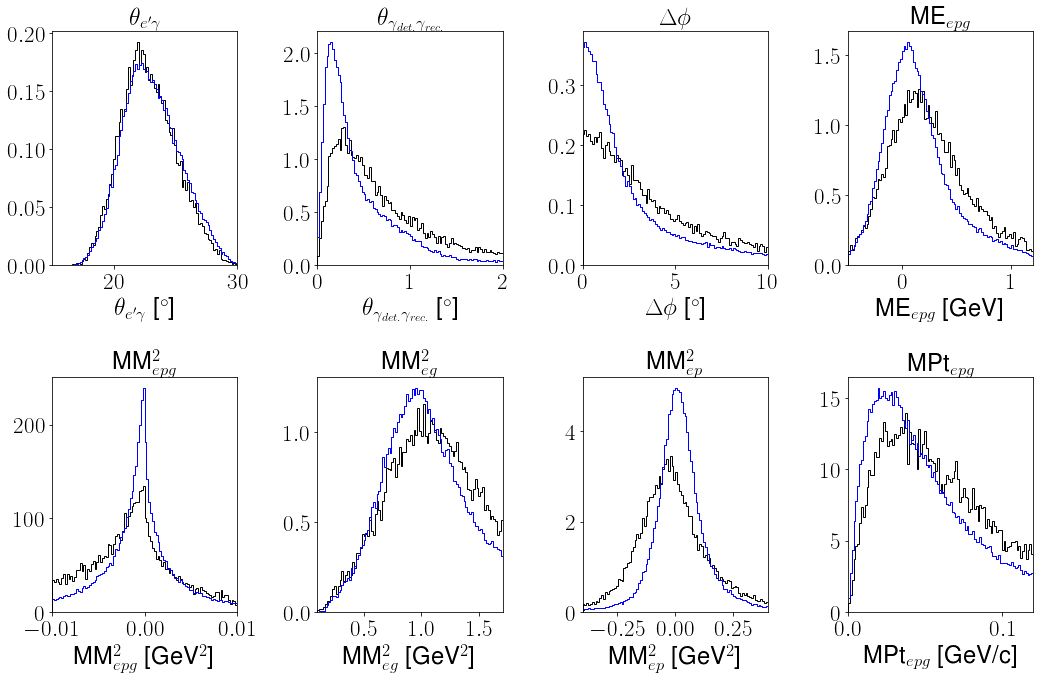

<Figure size 432x288 with 0 Axes>

In [277]:
varstoplot = ["coneAngle", "reconGam", "coplanarity", "ME_epg", "MM2_epg", "MM2_eg", "MM2_ep", "MPt"]
title = [r"$\theta_{e'\gamma}$", r"$\theta_{\gamma_{det.}\gamma_{rec.}}$", r"$\Delta\phi$" , "ME"+r"${}_{epg}$", "MM"+r"${}^{2}_{epg}$", "MM"+r"${}^{2}_{eg}$", "MM"+r"${}^{2}_{ep}$", "MPt"+r"${}_{epg}$"]
unit = [degree, degree, degree, GeV, GeV2, GeV2, GeV2, GeVc]
binstarts = [15, 0, 0, -0.5, -0.01, 0.1,-0.4 , 0]
binends = [30, 2, 10, 1.2, 0.01, 1.7, 0.4, 0.12]
fig, axs = plt.subplots(2, 4, figsize = (15,10))
for yind in range(0, 2):
    for xind in range(0,4):
        ind = 4*yind + xind
        start = binstarts[ind]
        end = binends[ind]
        bins = np.linspace(start, end, 101)
        simDist_dvpi0, bins = np.histogram(bkgSimInbCD_bin1[varstoplot[ind]], bins, density = True)
        simDist_dvcs, bins = np.histogram(dvcsSimInbCD_bin1[varstoplot[ind]], bins, density = True)
#         simDist = len_pi0ExpInbCD_bin1/len_pi0SimInbCD_bin1*simDist_dvpi0 + (len_epgExpInbCD_bin1/len_dvcsSimInbCD_bin1-len_bkgSimInbCD_bin1/len_pi0SimInbCD_bin1*len_pi0ExpInbCD_bin1/len_dvcsSimInbCD_bin1)*simDist_dvcs
        simDist = (1-contCD_bin1)*simDist_dvcs + contCD_bin1*simDist_dvpi0
        expDist, bins = np.histogram(epgExpInbCD_bin1[varstoplot[ind]], bins, density=True)
        bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
        axs[yind, xind].step(bincenters, simDist, where='mid',color='b', linewidth=1)
#         axs[yind, xind].step(bincenters, c*simDist_dvpi0, where='mid',color='g', linewidth=1)
#         axs[yind, xind].step(bincenters, (1/len_dvcsSimInbCD_bin1-cont_inb_CD_bin1/len_dvcsSimInbCD_bin1)*len_epgExpInbCD_bin1*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].hist(epgExpInbCD_bin1[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', density=True, linewidth=1)
#         axs[yind, xind].hist(epgExpInbCD_bin1[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', linewidth=1)
#         axs[yind, xind].step(bincenters, expDist - len_pi0ExpInbCD_bin1/len_pi0SimInbCD_bin1*simDist_dvpi0, where='mid',color='k', linewidth=1)
        print(varstoplot[ind], nphistmean(expDist - len(pi0ExpInbCD_bin1)/len(pi0SimInbCD_bin1)*simDist_dvpi0, bins))
#         axs[yind, xind].step(bincenters, (1-c)*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].set_title(title[ind])
        axs[yind, xind].set_xlim([start, end])
        if (unit[ind]):
            axs[yind, xind].set_xlabel(title[ind]+" [" + unit[ind] +"]")
        else:
            axs[yind, xind].set_xlabel(title[ind])
# axs[0,2].set_xticks([2.2, 2.7, 3.2])
# axs[1,0].set_xticks([0.29, 0.32, 0.35, 0.38])
# axs[1,1].set_xticks([0.23, 0.3, 0.39, 0.52])
# axs[1,2].set_xticks([0, 90, 180, 270, 360])
plt.tight_layout()
# plt.savefig("kineCD_bin1.pdf")
# plt.savefig("analysisnote/inbending1.pdf")
plt.show()
plt.clf()

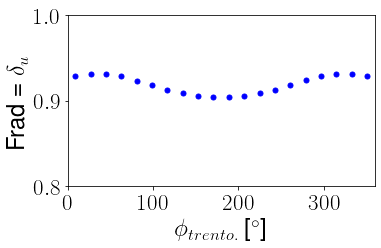

In [265]:
plt.errorbar(binscenters, Frad, color='b', fmt='.', markersize=10)
plt.xlim([0, 360])
plt.ylim([0.8, 1])
plt.ylabel("Frad = "+r"$\delta_u$")
plt.xlabel(r"$\phi_{trento.}$"+" ["+degree+"]")
plt.show()

In [280]:
bins = np.linspace(0, 360, 21)
binscenters = np.array([0.5 * (bins[i] + bins[i + 1])
                        for i in range(len(bins) - 1)])
gen = gen_bin1
expDistFD, bins = np.histogram(epgExpInbFD_bin1.phi2, bins = bins)
simDistFD_dvpi0, bins = np.histogram(bkgSimInbFD_bin1.phi2, bins = bins)
simDistFD_dvcs, bins = np.histogram(dvcsSimInbFD_bin1.phi2, bins = bins)
dvcsFD = expDistFD - len(pi0ExpInbFD)/len(pi0SimInbFD)*simDistFD_dvpi0

expDistCD, bins = np.histogram(epgExpInbCD_bin1.phi2, bins = bins)
simDistCD_dvpi0, bins = np.histogram(bkgSimInbCD_bin1.phi2, bins = bins)
simDistCD_dvcs, bins = np.histogram(dvcsSimInbCD_bin1.phi2, bins = bins)
dvcsCD = expDistCD - len(pi0ExpInbCD)/len(pi0SimInbCD)*simDistCD_dvpi0


In [293]:
accCD

array([6.16282573e-01, 6.59496005e-01, 5.77593828e-01, 4.61544984e-01,
       3.65207057e-01, 2.71832965e-01, 1.06806741e-01, 2.00539463e-02,
       1.48864905e-03, 2.52876470e-04, 3.72347027e-04, 1.91754554e-03,
       9.67519005e-03, 4.91767289e-02, 1.50939604e-01, 2.00018650e-01,
       2.10812187e-01, 2.63367108e-01, 3.91287616e-01, 5.55117513e-01])

In [356]:
accFD = simDistFD_dvcs/gen_bin1
accCorrectedSigFD = copy(accFD)
accCorrectedUncFD = copy(accFD)
for it, val in enumerate(accFD):
    if val <0.1:
        accCorrectedSigFD[it] = 0
        accCorrectedUncFD[it] = 0
    elif dvcs[it]<=0:
        accCorrectedSigFD[it] = 0
        accCorrectedUncFD[it] = 0
    else:
        accCorrectedSigFD[it] = dvcsFD[it]/val#simDist_dvcs[it]/val
        accCorrectedUncFD[it] = np.sqrt(1/expDistFD[it] + (1/expDistFD[it])*(1+contFD)*(contFD/(1-contFD))**2 + (1-val)/val/gen[it])

accCD = simDistCD_dvcs/gen_bin1
accCorrectedSigCD = copy(accCD)
accCorrectedUncCD = copy(accCD)
for it, val in enumerate(accCD):
    if val <0.1:
        accCorrectedSigCD[it] = 0
        accCorrectedUncCD[it] = 0
    elif dvcsCD[it]<=0:
        accCorrectedSigCD[it] = 0
        accCorrectedUncCD[it] = 0
    else:
        accCorrectedSigCD[it] = dvcsCD[it]/val#simDist_dvcs[it]/val
        accCorrectedUncCD[it] = np.sqrt(1/expDistCD[it] + (1/expDistCD[it])*(1+contCD)*(contCD/(1-contCD))**2+ 1/simDistCD_dvcs[it] + (1-val)/val/gen[it])

In [357]:
# dvcsFD
accCorrectedSigFD

array([   0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        , 1242.9514712 ,
       1137.99471215, 1228.55935628, 1240.1010215 , 1162.86525979,
       1058.5909802 ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ])

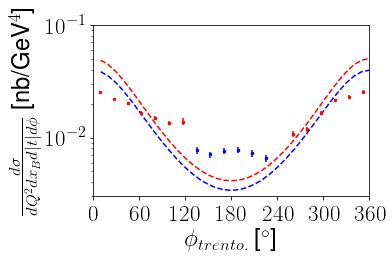

In [359]:
bhphi = [10*i+10 for i in range(36)]
plt.errorbar(binscenters, accCorrectedSigFD/56.5/0.1/1/0.1/(np.pi*2/20)/10**6/Frad, yerr = accCorrectedSigFD/56.5/0.1/1/0.1/(np.pi*2/20)/10**6*accCorrectedUncFD/Frad, color='b', fmt='.', markersize=5)
plt.errorbar(binscenters, accCorrectedSigCD/56.5/0.1/1/0.1/(np.pi*2/20)/10**6/Frad, yerr = accCorrectedSigCD/56.5/0.1/1/0.1/(np.pi*2/20)/10**6*accCorrectedUncCD/Frad, color='r', fmt='.', markersize=5)
plt.plot(bhphi, bhFD_bin1, color = 'blue', linestyle = '--')
plt.plot(bhphi, np.array(bhCD_bin1), color = 'red', linestyle = '--')
# plt.plot(binscenters, accCorrectedSig/40000)
# plt.ylim([0.00001,1])
plt.ylabel(r"$\frac{d\sigma}{dQ^2 dx_B d|t| d\phi}$" + " [nb/GeV"+r"${}^{4}$"+"]")
plt.xlabel(r"$\phi_{trento.}$"+" ["+degree+"]")
plt.xticks(np.linspace(0, 360, 7))
plt.xlim([0, 360])
plt.ylim([0.05, 0.1])
plt.tick_params(axis='y', which='minor')
plt.gca().yaxis.set_minor_formatter(plt.FormatStrFormatter("%.1f"))
plt.yticks([0.003, 0.01, 0.03, 0.1])
plt.yscale('log')
plt.show()

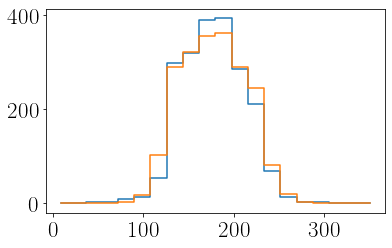

In [311]:
plt.step(binscenters, dvcsFD, where = 'mid')
plt.step(binscenters, (len(epgExpInbFD_bin1)/len(dvcsSimInbFD_bin1)-len(bkgSimInbFD_bin1)/len(pi0SimInbFD_bin1)*len(pi0ExpInbFD_bin1)/len(dvcsSimInbFD_bin1))*simDistFD_dvcs, where = 'mid')

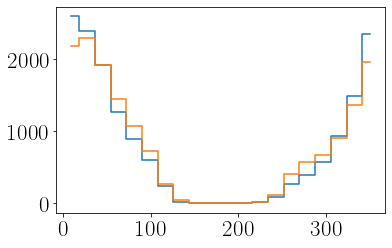

In [312]:
plt.step(binscenters, dvcsCD, where = 'mid')
plt.step(binscenters, (len(epgExpInbCD_bin1)/len(dvcsSimInbCD_bin1)-len(bkgSimInbCD_bin1)/len(pi0SimInbCD_bin1)*len(pi0ExpInbCD_bin1)/len(dvcsSimInbCD_bin1))*simDistCD_dvcs, where = 'mid')

In [309]:
simDist_dvcs

array([7.61321695e-03, 7.68762836e-03, 7.40858559e-03, 7.83180046e-03,
       7.51555198e-03, 7.98527398e-03, 8.38988600e-03, 8.10619252e-03,
       7.89225973e-03, 7.54810697e-03, 7.52020270e-03, 6.66912224e-03,
       6.83654791e-03, 6.23660595e-03, 6.16219454e-03, 5.38087478e-03,
       5.61806114e-03, 5.22740126e-03, 4.77628211e-03, 4.31121082e-03,
       4.10192874e-03, 3.71126886e-03, 3.69266601e-03, 3.59965175e-03,
       3.47408251e-03, 2.98575766e-03, 2.93925053e-03, 2.57184421e-03,
       2.16723219e-03, 1.93004584e-03, 1.50683097e-03, 1.13012323e-03,
       8.97587582e-04, 5.85989821e-04, 4.18564158e-04, 3.20899187e-04,
       1.62774950e-04, 1.39521386e-04, 1.25569247e-04, 4.65071286e-05,
       9.30142572e-06, 2.32535643e-05, 9.30142572e-06, 1.39521386e-05,
       0.00000000e+00, 0.00000000e+00, 4.65071286e-06, 0.00000000e+00,
       4.65071286e-06, 0.00000000e+00, 4.65071286e-06, 4.65071286e-06,
       0.00000000e+00, 4.65071286e-06, 0.00000000e+00, 4.65071286e-06,
      

In [174]:
len(pi0ExpInbFD_bin1)/len(pi0SimInbFD_bin1)*len(bkgSimInbFD_bin1)/len(epgExpInbFD_bin1)

0.34236808054491075

In [173]:
len(pi0ExpInbFD)/len(pi0SimInbFD)*len(bkgSimInbFD)/len(epgExpInbFD)

0.4318811519935963

In [76]:
len(bkgSimInbFD_bin1)

548

In [77]:
len(bkgSimInbFD)

198963

In [117]:
expDist

array([ 0,  0,  0,  1,  0,  0,  8, 30, 16, 33, 19, 24, 25, 13,  2,  0,  0,
        0,  0,  0])

<AxesSubplot:>

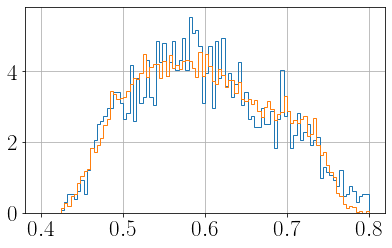

In [410]:
epgExpInbFD_bin1.Pp.hist(bins = np.linspace(0.4, 0.8, 101), density = True, histtype = 'step')
dvcsSimInbFD_bin1.Pp.hist(bins = np.linspace(0.4, 0.8, 101), density = True, histtype = 'step')

<AxesSubplot:>

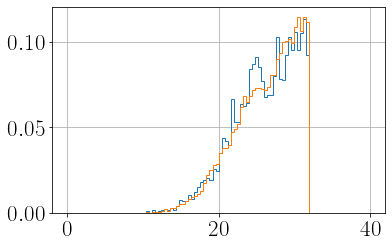

In [411]:
epgExpInbFD_bin1.Ptheta.hist(bins = np.linspace(0, 40, 101), density = True, histtype = 'step')
dvcsSimInbFD_bin1.Ptheta.hist(bins = np.linspace(0, 40, 101), density = True, histtype = 'step')

<AxesSubplot:>

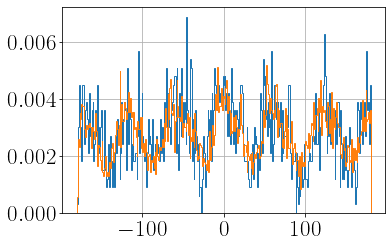

In [414]:
epgExpInbFD_bin1.Pphi.hist(bins = np.linspace(-180, 180, 361), density = True, histtype = 'step')
dvcsSimInbFD_bin1.Pphi.hist(bins = np.linspace(-180, 180, 361), density = True, histtype = 'step')

coneAngle 18.855299105345896
reconGam 0.5169203813088276
coplanarity 2.0260627390912758
ME_epg 0.3344846866307385
MM2_epg -0.0023094336103841573
MM2_eg 1.2819980746351582
MM2_ep -0.014449032924289774
MPt 0.043626656075980666


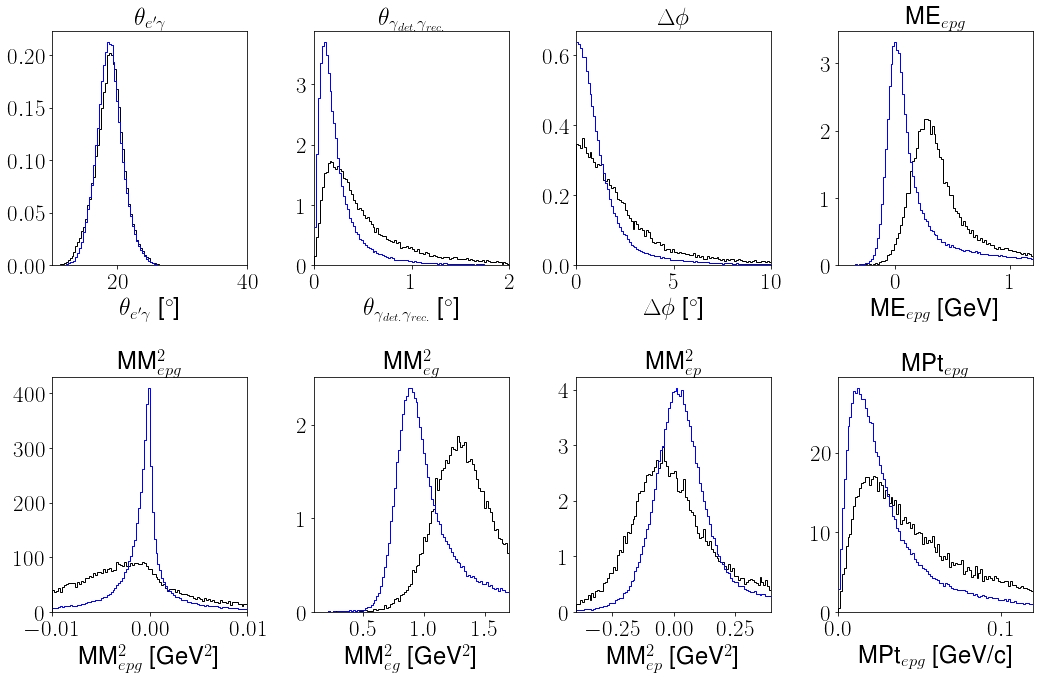

<Figure size 432x288 with 0 Axes>

In [425]:
contCDFT = len(pi0ExpInbCDFT)*len(bkgSimInbCDFT)/len(pi0SimInbCDFT)/len(epgExpInbCDFT)

varstoplot = ["coneAngle", "reconGam", "coplanarity", "ME_epg", "MM2_epg", "MM2_eg", "MM2_ep", "MPt"]
title = [r"$\theta_{e'\gamma}$", r"$\theta_{\gamma_{det.}\gamma_{rec.}}$", r"$\Delta\phi$" , "ME"+r"${}_{epg}$", "MM"+r"${}^{2}_{epg}$", "MM"+r"${}^{2}_{eg}$", "MM"+r"${}^{2}_{ep}$", "MPt"+r"${}_{epg}$"]
unit = [degree, degree, degree, GeV, GeV2, GeV2, GeV2, GeVc]
binstarts = [10, 0, 0, -0.5, -0.01, 0.1,-0.4 , 0]
binends = [40, 2, 10, 1.2, 0.01, 1.7, 0.4, 0.12]
fig, axs = plt.subplots(2, 4, figsize = (15,10))
for yind in range(0, 2):
    for xind in range(0,4):
        ind = 4*yind + xind
        start = binstarts[ind]
        end = binends[ind]
        bins = np.linspace(start, end, 101)
        simDist_dvpi0, bins = np.histogram(bkgSimInbCDFT[varstoplot[ind]], bins, density = True)
        simDist_dvcs, bins = np.histogram(dvcsSimInbCDFT[varstoplot[ind]], bins, density = True)
#         simDist = len_pi0ExpInbCDFT/len_pi0SimInbCDFT*simDist_dvpi0 + (len_epgExpInbCDFT/len_dvcsSimInbCDFT-len_bkgSimInbCDFT/len_pi0SimInbCDFT*len_pi0ExpInbCDFT/len_dvcsSimInbCDFT)*simDist_dvcs
        simDist = (1-contCDFT)*simDist_dvcs + contCDFT*simDist_dvpi0
        expDist, bins = np.histogram(epgExpInbCDFT[varstoplot[ind]], bins, density=True)
        bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
        axs[yind, xind].step(bincenters, simDist, where='mid',color='b', linewidth=1)
#         axs[yind, xind].step(bincenters, c*simDist_dvpi0, where='mid',color='g', linewidth=1)
#         axs[yind, xind].step(bincenters, (1/len_dvcsSimInbCDFT-cont_inb_CDFT/len_dvcsSimInbCDFT)*len_epgExpInbCDFT*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].hist(epgExpInbCDFT[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', density=True, linewidth=1)
#         axs[yind, xind].hist(epgExpInbCDFT[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', linewidth=1)
#         axs[yind, xind].step(bincenters, expDist - len_pi0ExpInbCDFT/len_pi0SimInbCDFT*simDist_dvpi0, where='mid',color='k', linewidth=1)
        print(varstoplot[ind], nphistmean(expDist - len(pi0ExpInbCDFT)/len(pi0SimInbCDFT)*simDist_dvpi0, bins))
#         axs[yind, xind].step(bincenters, (1-c)*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].set_title(title[ind])
        axs[yind, xind].set_xlim([start, end])
        if (unit[ind]):
            axs[yind, xind].set_xlabel(title[ind]+" [" + unit[ind] +"]")
        else:
            axs[yind, xind].set_xlabel(title[ind])
# axs[0,2].set_xticks([2.2, 2.7, 3.2])
# axs[1,0].set_xticks([0.29, 0.32, 0.35, 0.38])
# axs[1,1].set_xticks([0.23, 0.3, 0.39, 0.52])
# axs[1,2].set_xticks([0, 90, 180, 270, 360])
plt.tight_layout()
# plt.savefig("kineCDFT.pdf")
# plt.savefig("analysisnote/inbending1.pdf")
plt.show()
plt.clf()

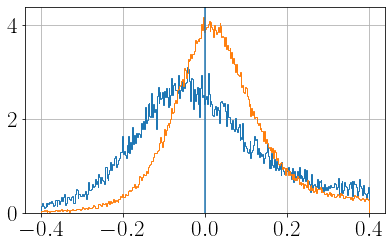

In [428]:
epgExpInbCDFT.MM2_ep.hist(bins = np.linspace(-0.4, 0.4, 361), density = True, histtype = 'step')
dvcsSimInbCDFT.MM2_ep.hist(bins = np.linspace(-0.4, 0.4, 361), density = True, histtype = 'step')
plt.axvline(0)
plt.show()

<AxesSubplot:>

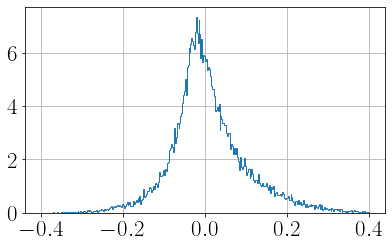

In [432]:
(epgExpInbCDFT.t2-epgExpInbCDFT.t1).hist(bins = np.linspace(-0.4, 0.4, 361), density = True, histtype = 'step')


<AxesSubplot:>

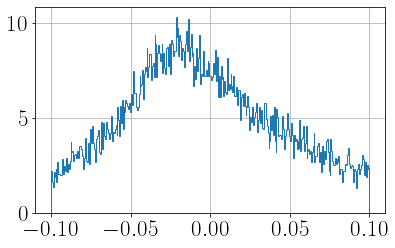

In [433]:
(epgExpInbCDFT.t2-epgExpInbCDFT.t1).hist(bins = np.linspace(-0.1, 0.1, 361), density = True, histtype = 'step')


<AxesSubplot:>

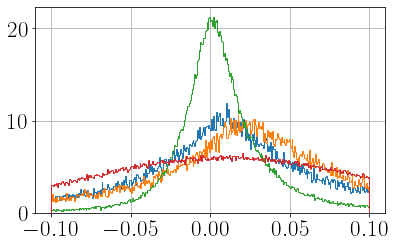

In [514]:
(epgExpInbFD.t2-epgExpInbFD.t1).hist(bins = np.linspace(-0.1, 0.1, 361), density = True, histtype = 'step')
(epgExpInbFD_noCorr.t2-epgExpInbFD_noCorr.t1).hist(bins = np.linspace(-0.1, 0.1, 361), density = True, histtype = 'step')
(dvcsSimInbFD.t2-dvcsSimInbFD.t1).hist(bins = np.linspace(-0.1, 0.1, 361), density = True, histtype = 'step')
(pi0SimInbFD.t2-pi0SimInbFD.t1).hist(bins = np.linspace(-0.1, 0.1, 361), density = True, histtype = 'step')


<AxesSubplot:>

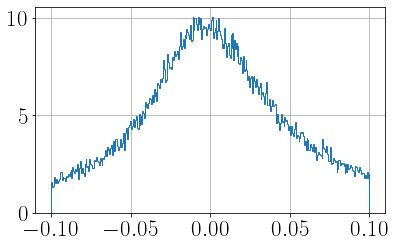

In [435]:
(epgExpInbCD.t2-epgExpInbCD.t1).hist(bins = np.linspace(-0.1, 0.1, 361), density = True, histtype = 'step')


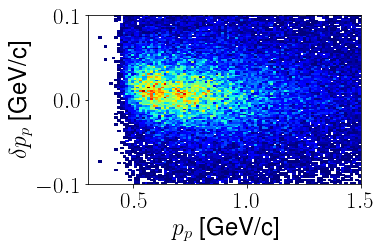

In [477]:
plt.hist2d(epgExpInbFD.Pp, np.sqrt((epgExpInbFD.Pe + (epgExpInbFD.t2 - epgExpInbFD.t1)/2/M)**2-M**2)-epgExpInbFD.Pp, bins = [np.linspace(0.3, 1.5, 101), np.linspace(-0.1, 0.1, 101)], cmap = cmap, cmin = 1)
plt.xlabel(r"$p_p$"+" ["+GeVc+"]")
plt.ylabel(r"$\delta p_p$"+" ["+GeVc+"]")


plt.show()

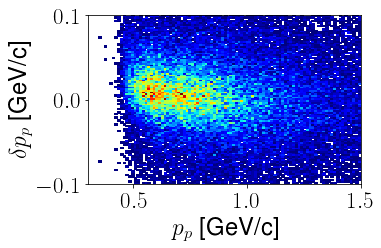

In [529]:
plt.hist2d(epgExpInbFD.Pp, np.sqrt(epgExpInbFD.t2**2/4/M+epgExpInbFD.t2)-epgExpInbFD.Pp, bins = [np.linspace(0.3, 1.5, 101), np.linspace(-0.1, 0.1, 101)], cmap = cmap, cmin = 1)
plt.xlabel(r"$p_p$"+" ["+GeVc+"]")
plt.ylabel(r"$\delta p_p$"+" ["+GeVc+"]")


plt.show()

<AxesSubplot:>

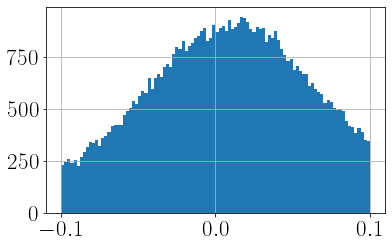

In [500]:
((pi0ExpInbFD.t2 - pi0ExpInbFD.t1)/2/M).hist(bins = np.linspace(-0.1, 0.1, 101))

<AxesSubplot:>

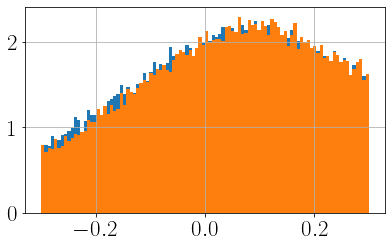

In [501]:
(pi0ExpInbFD.ME_epgg-(pi0ExpInbFD.t2 - pi0ExpInbFD.t1)/2/M).hist(bins = np.linspace(-0.3, 0.3, 101), density = True)
(pi0ExpInbFD.ME_epgg).hist(bins = np.linspace(-0.3, 0.3, 101), density = True)

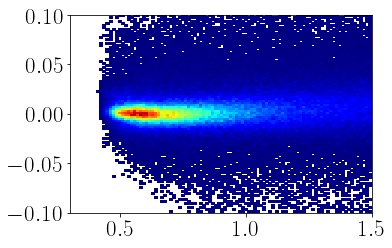

In [479]:
plt.hist2d(dvcsSimInbFD.Pp, (dvcsSimInbFD.t2 - dvcsSimInbFD.t1)/2/M, bins = [np.linspace(0.3, 1.5, 101), np.linspace(-0.1, 0.1, 101)], cmap = cmap, cmin = 1)
plt.show()

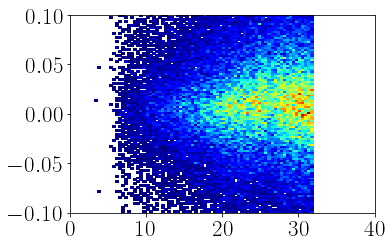

In [480]:
plt.hist2d(epgExpInbFD.Ptheta, np.sqrt((epgExpInbFD.Pe + (epgExpInbFD.t2 - epgExpInbFD.t1)/2/M)**2-M**2)-epgExpInbFD.Pp, bins = [np.linspace(0, 40, 101), np.linspace(-0.1, 0.1, 101)], cmap = cmap, cmin = 1)
plt.show()

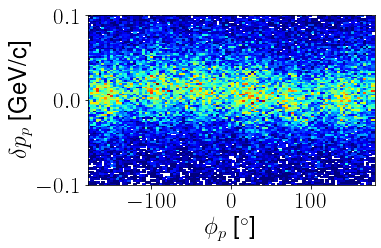

In [482]:
plt.hist2d(epgExpInbFD.Pphi, np.sqrt((epgExpInbFD.Pe + (epgExpInbFD.t2 - epgExpInbFD.t1)/2/M)**2-M**2)-epgExpInbFD.Pp, bins = [np.linspace(-180, 180, 101), np.linspace(-0.1, 0.1, 101)], cmap = cmap, cmin = 1)
plt.xlabel(r"$\phi_p$"+" ["+degree+"]")
plt.ylabel(r"$\delta p_p$"+" ["+GeVc+"]")


plt.show()

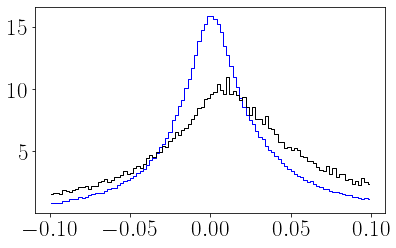

In [452]:
bins = np.linspace(-0.1, 0.1, 101)
simDist_dvpi0, bins = np.histogram(bkgSimInbFD.t2 - bkgSimInbFD.t1, bins, density = True)
simDist_dvcs, bins = np.histogram(dvcsSimInbFD.t2 - dvcsSimInbFD.t1, bins, density = True)
#         simDist = len_pi0ExpInbFD/len_pi0SimInbFD*simDist_dvpi0 + (len_epgExpInbFD/len_dvcsSimInbFD-len_bkgSimInbFD/len_pi0SimInbFD*len_pi0ExpInbFD/len_dvcsSimInbFD)*simDist_dvcs
simDist = (1-contFD)*simDist_dvcs + contFD*simDist_dvpi0
expDist, bins = np.histogram(epgExpInbFD.t2 - epgExpInbFD.t1, bins, density=True)
bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
plt.step(bincenters, simDist, where='mid',color='b', linewidth=1)
plt.step(bincenters, expDist, where='mid',color='k', linewidth=1)
#         axs[yind, xind].step(bincenters, c*simDist_dvpi0, where='mid',color='g', linewidth=1)
#         axs[yind, xind].step(bincenters, (1/len_dvcsSimInbFD-cont_inb_FD/len_dvcsSimInbFD)*len_epgExpInbFD*simDist_dvcs, where='mid',color='r', linewidth=1)
# axs[yind, xind].hist(epgExpInbFD[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', density=True, linewidth=1)
#         axs[yind, xind].hist(epgExpInbFD[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', linewidth=1)
#         axs[yind, xind].step(bincenters, expDist - len_pi0ExpInbFD/len_pi0SimInbFD*simDist_dvpi0, where='mid',color='k', linewidth=1)
# print(nphistmean(expDist - len(pi0ExpInbFD)/len(pi0SimInbFD)*simDist_dvpi0, bins))
# plt.hist(expDist - len(pi0ExpInbFD)/len(pi0SimInbFD)*simDist_dvpi0, bins = bins)

In [ ]:
bins = np.linspace(-0.1, 0.1, 101)
simDist_dvpi0, bins = np.histogram(bkgSimInbFD.t2 - bkgSimInbFD.t1, bins, density = True)
simDist_dvcs, bins = np.histogram(dvcsSimInbFD.t2 - dvcsSimInbFD.t1, bins, density = True)
#         simDist = len_pi0ExpInbFD/len_pi0SimInbFD*simDist_dvpi0 + (len_epgExpInbFD/len_dvcsSimInbFD-len_bkgSimInbFD/len_pi0SimInbFD*len_pi0ExpInbFD/len_dvcsSimInbFD)*simDist_dvcs
simDist = (1-contFD)*simDist_dvcs + contFD*simDist_dvpi0
expDist, bins = np.histogram(epgExpInbFD.t2 - epgExpInbFD.t1, bins, density=True)
bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
plt.step(bincenters, simDist, where='mid',color='b', linewidth=1)
plt.step(bincenters, expDist, where='mid',color='k', linewidth=1)
#         axs[yind, xind].step(bincenters, c*simDist_dvpi0, where='mid',color='g', linewidth=1)
#         axs[yind, xind].step(bincenters, (1/len_dvcsSimInbFD-cont_inb_FD/len_dvcsSimInbFD)*len_epgExpInbFD*simDist_dvcs, where='mid',color='r', linewidth=1)
# axs[yind, xind].hist(epgExpInbFD[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', density=True, linewidth=1)
#         axs[yind, xind].hist(epgExpInbFD[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', linewidth=1)
#         axs[yind, xind].step(bincenters, expDist - len_pi0ExpInbFD/len_pi0SimInbFD*simDist_dvpi0, where='mid',color='k', linewidth=1)
# print(nphistmean(expDist - len(pi0ExpInbFD)/len(pi0SimInbFD)*simDist_dvpi0, bins))
# plt.hist(expDist - len(pi0ExpInbFD)/len(pi0SimInbFD)*simDist_dvpi0, bins = bins)

In [458]:
exp_1g = pd.read_pickle("/Volumes/Extreme SSD/data/exp/convPkl_noCorr/inb/dvcs_inb_noCorr.pkl")

In [460]:
epgExpInbFD_noCorr = exp_1g.loc[(exp_1g.Ee>3)&(exp_1g.Ge>2)&((exp_1g.Psector<7)&(exp_1g.Ptheta<32))& (exp_1g.Gsector<7)]


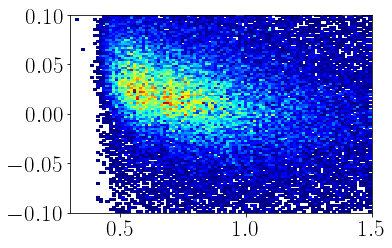

In [527]:
plt.hist2d(epgExpInbFD_noCorr.Pp, np.sqrt(epgExpInbFD_noCorr.t2**2/4/M+epgExpInbFD_noCorr.t2)-epgExpInbFD_noCorr.Pp, bins = [np.linspace(0.3, 1.5, 101), np.linspace(-0.1, 0.1, 101)], cmap = cmap, cmin = 1)
plt.show()#(epgExpInbFD_noCorr.t2 - epgExpInbFD_noCorr.t1)/2/M

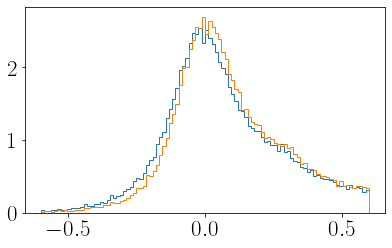

In [504]:
plt.hist(epgExpInbFD_noCorr.MM2_ep, bins = np.linspace(-0.6, 0.6, 101), histtype = 'step', density = True)
plt.hist(epgExpInbFD.MM2_ep, bins = np.linspace(-0.6, 0.6, 101), histtype = 'step', density = True)
plt.show()

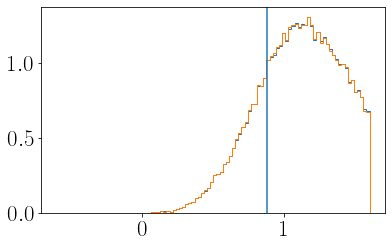

In [569]:
plt.hist(epgExpInbFD_noCorr.MM2_eg, bins = np.linspace(-0.6, 1.6, 101), histtype = 'step', density = True)
plt.hist(epgExpInbFD.MM2_eg, bins = np.linspace(-0.6, 1.6, 101), histtype = 'step', density = True)
# plt.hist(pi0ExpInbFD.MM2_egg, bins = np.linspace(-0.6, 1.6, 101), histtype = 'step', density = True)
plt.axvline(M**2)
plt.show()

In [518]:
np.sqrt(epgExpInbFD_noCorr.t2**2/4/M/M/+epgExpInbFD_noCorr.t2)

155        0.639844
292        0.514835
402        0.310161
524        0.290629
550        0.822787
             ...   
3662900    0.494921
3662997    0.337468
3663116    0.299174
3663134    0.592580
3663178    0.617117
Name: t2, Length: 58737, dtype: float64

In [520]:
epgExpInbFD_noCorr.Pp

155        1.419690
292        1.069575
402        0.623293
524        0.495677
550        2.052844
             ...   
3662900    0.937443
3662997    0.644666
3663116    0.552376
3663134    1.282042
3663178    1.299415
Name: Pp, Length: 58737, dtype: float64

<AxesSubplot:>

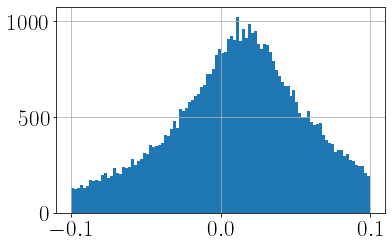

In [526]:
(np.sqrt(epgExpInbFD_noCorr.t2**2/4/M+epgExpInbFD_noCorr.t2)-epgExpInbFD_noCorr.Pp).hist(bins = np.linspace(-0.1, 0.1, 101))

<AxesSubplot:>

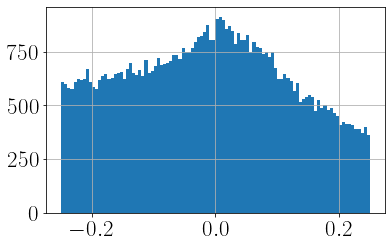

In [606]:
# (dvcsSimInbFD.nu - dvcsSimInbFD.t2/M/2).hist(bins = 101)

((dvcsSimInbFD.nu - dvcsSimInbFD.t2/M/2)-dvcsSimInbFD.GenGp).hist(bins = np.linspace(-0.25, 0.25, 101))
# (dvcsSimInbFD.Gp-dvcsSimInbFD.GenGp).hist(bins = np.linspace(-0.25, 0.25, 101))


<AxesSubplot:>

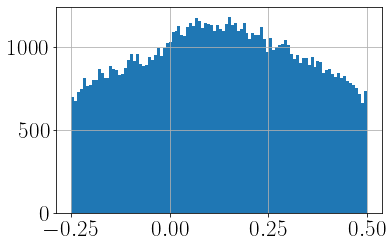

In [605]:
((bkgSimInbFD.nu - bkgSimInbFD.t2/M/2)-bkgSimInbFD.GenGp).hist(bins = np.linspace(-0.25, 0.5, 101))


<AxesSubplot:>

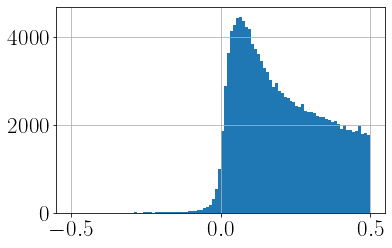

In [673]:
(bkgSimInbFD.Gp-bkgSimInbFD.GenGp).hist(bins = np.linspace(-0.5, 0.5, 101))


In [722]:
def reDefineDVCS(df_epg):

    df_epg.loc[:, 'newPe'] = df_epg.t2/2/M + M
    df_epg.loc[:, 'newPp'] = np.sqrt(df_epg.newPe**2 - M**2)
    df_epg.loc[:, 'newGp'] = df_epg.nu - df_epg.t2/M/2
    
    df_epg.loc[:, 'dPp'] = df_epg.loc[:, 'newPp'] -  df_epg.loc[:, 'Pp']
    df_epg.loc[:, 'dGp'] = df_epg.loc[:, 'newGp'] -  df_epg.loc[:, 'Gp']

    return df_epg



In [742]:
bkgSimInbFD = reDefineDVCS(bkgSimInbFD)
dvcsSimInbFD = reDefineDVCS(dvcsSimInbFD)
epgExpInbFD = reDefineDVCS(epgExpInbFD)

bkgSimInbCD = reDefineDVCS(bkgSimInbCD)
dvcsSimInbCD = reDefineDVCS(dvcsSimInbCD)
epgExpInbCD = reDefineDVCS(epgExpInbCD)

<AxesSubplot:>

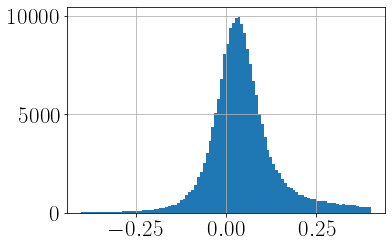

In [692]:
bkgSimInbFD.MM2_ep.hist(bins = np.linspace(-0.4, 0.4, 101))

nu 5.189340702178969
xB 0.42353464127592294
W 2.5233932402184505
t2 0.677581278065937
Q2 4.1632905793296215
phi2 174.52967010349488


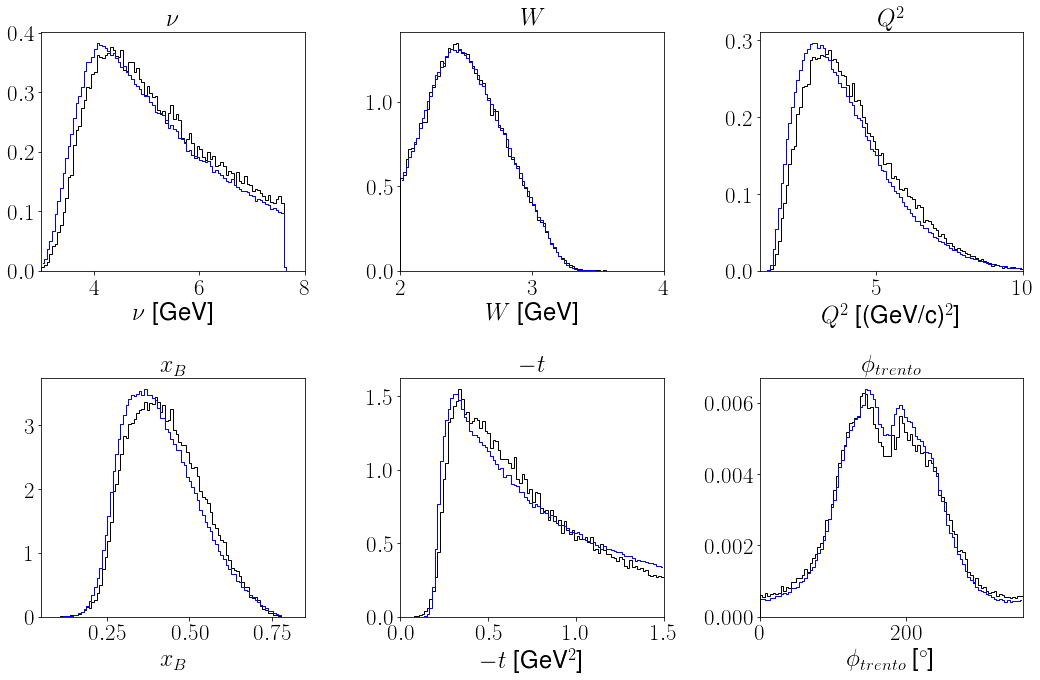

<Figure size 432x288 with 0 Axes>

In [671]:
varstoplot = ["nu", "W", "Q2", "xB", "t2", "phi2"]
title = [r"$\nu$", r"$W$", r"$Q^{2}$", r"$x_{B}$", r"$-t$", r"$\phi_{trento}$" ]
unit = [GeV, GeV, GeVc2, None, GeV2, degree, GeV2, degree]
binstarts = [3, 2, 1, 0.05, 0, 0]
binends = [8, 4, 10, 0.85, 1.5, 360]
fig, axs = plt.subplots(2, 3, figsize = (15, 10))
for xind in range(0,3):
    for yind in range(0, 2):
        ind =xind+3*yind
        start = binstarts[ind]
        end = binends[ind]
        bins = np.linspace(start, end, 101)
        simDist_dvpi0, bins = np.histogram(bkgSimInbFD[varstoplot[ind]], bins, density = True)
        simDist_dvcs, bins = np.histogram(dvcsSimInbFD[varstoplot[ind]], bins, density = True)
#         simDist = len_pi0ExpInbFD/len_pi0SimInbFD*simDist_dvpi0 + (len_epgExpInbFD/len_dvcsSimInbFD-len_bkgSimInbFD/len_pi0SimInbFD*len_pi0ExpInbFD/len_dvcsSimInbFD)*simDist_dvcs
        simDist = (1-contFD)*simDist_dvcs + contFD*simDist_dvpi0
        expDist, bins = np.histogram(epgExpInbFD[varstoplot[ind]], bins, density=True)
        bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
        axs[yind, xind].step(bincenters, simDist, where='mid',color='b', linewidth=1)
#         axs[yind, xind].step(bincenters, c*simDist_dvpi0, where='mid',color='g', linewidth=1)
#         axs[yind, xind].step(bincenters, (1/len_dvcsSimInbFD-cont_inb_FD/len_dvcsSimInbFD)*len_epgExpInbFD*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].hist(epgExpInbFD[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', density=True, linewidth=1)
#         axs[yind, xind].hist(epgExpInbFD[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', linewidth=1)
#         axs[yind, xind].step(bincenters, expDist - len_pi0ExpInbFD/len_pi0SimInbFD*simDist_dvpi0, where='mid',color='k', linewidth=1)
        print(varstoplot[ind], nphistmean(expDist - len(pi0ExpInbFD)/len(pi0SimInbFD)*simDist_dvpi0, bins))
#         axs[yind, xind].step(bincenters, (1-c)*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].set_title(title[ind])
        axs[yind, xind].set_xlim([start, end])
        if (unit[ind]):
            axs[yind, xind].set_xlabel(title[ind]+" [" + unit[ind] +"]")
        else:
            axs[yind, xind].set_xlabel(title[ind])
# axs[0,2].set_xticks([2.2, 2.7, 3.2])
# axs[1,0].set_xticks([0.29, 0.32, 0.35, 0.38])
# axs[1,1].set_xticks([0.23, 0.3, 0.39, 0.52])
# axs[1,2].set_xticks([0, 90, 180, 270, 360])
plt.tight_layout()
# plt.savefig("kineFD.pdf")
# plt.savefig("analysisnote/inbending1.pdf")
plt.show()
plt.clf()

coneAngle 34.906631382424905
reconGam 0.8902117536730172
coplanarity 4.844758978962467
ME_epg 0.004676021350126706
MM2_epg -0.007075672630249382
MM2_eg 0.876
MM2_ep 0.052465206511068195
MPt 0.04939618936472567


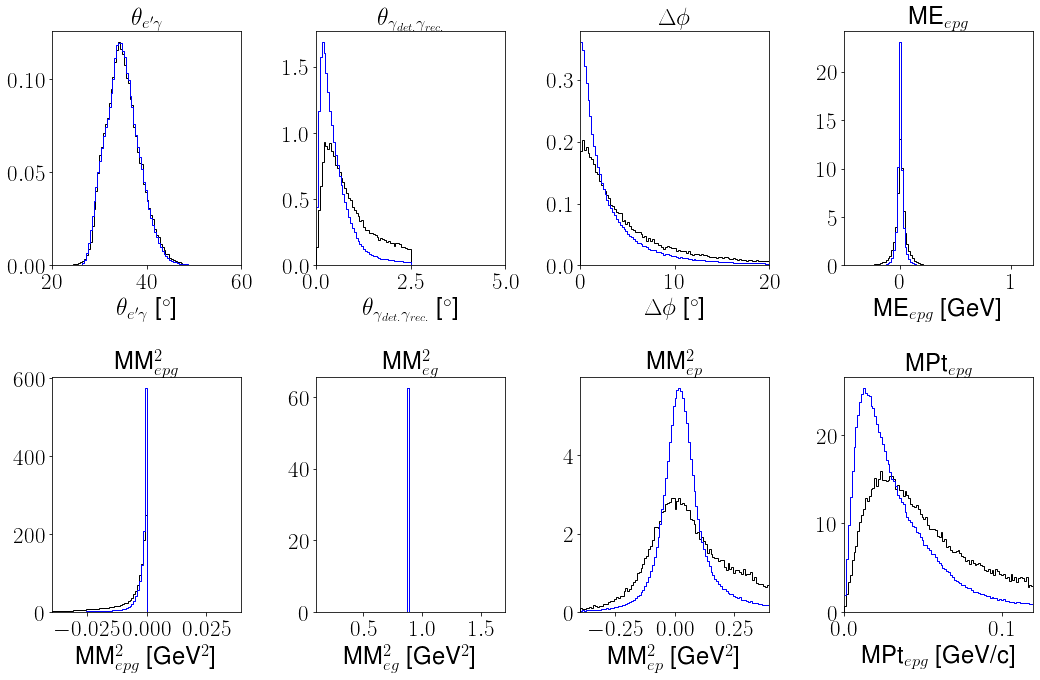

<Figure size 432x288 with 0 Axes>

In [672]:
varstoplot = ["coneAngle", "reconGam", "coplanarity", "ME_epg", "MM2_epg", "MM2_eg", "MM2_ep", "MPt"]
title = [r"$\theta_{e'\gamma}$", r"$\theta_{\gamma_{det.}\gamma_{rec.}}$", r"$\Delta\phi$" , "ME"+r"${}_{epg}$", "MM"+r"${}^{2}_{epg}$", "MM"+r"${}^{2}_{eg}$", "MM"+r"${}^{2}_{ep}$", "MPt"+r"${}_{epg}$"]
unit = [degree, degree, degree, GeV, GeV2, GeV2, GeV2, GeVc]
binstarts = [20, 0, 0, -0.5, -0.04, 0.1,-0.4 , 0]
binends = [60, 5, 20, 1.2, 0.04, 1.7, 0.4, 0.12]
fig, axs = plt.subplots(2, 4, figsize = (15,10))
for yind in range(0, 2):
    for xind in range(0,4):
        ind = 4*yind + xind
        start = binstarts[ind]
        end = binends[ind]
        bins = np.linspace(start, end, 101)
        simDist_dvpi0, bins = np.histogram(bkgSimInbFD[varstoplot[ind]], bins, density = True)
        simDist_dvcs, bins = np.histogram(dvcsSimInbFD[varstoplot[ind]], bins, density = True)
#         simDist = len_pi0ExpInbFD/len_pi0SimInbFD*simDist_dvpi0 + (len_epgExpInbFD/len_dvcsSimInbFD-len_bkgSimInbFD/len_pi0SimInbFD*len_pi0ExpInbFD/len_dvcsSimInbFD)*simDist_dvcs
        simDist = (1-contFD)*simDist_dvcs + contFD*simDist_dvpi0
        expDist, bins = np.histogram(epgExpInbFD[varstoplot[ind]], bins, density=True)
        bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
        axs[yind, xind].step(bincenters, simDist, where='mid',color='b', linewidth=1)
#         axs[yind, xind].step(bincenters, contFD*simDist_dvpi0, where='mid',color='g', linewidth=1)
#         axs[yind, xind].step(bincenters, (1/len_dvcsSimInbFD-cont_inb_FD/len_dvcsSimInbFD)*len_epgExpInbFD*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].hist(epgExpInbFD[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', density=True, linewidth=1)
#         axs[yind, xind].hist(epgExpInbFD[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', linewidth=1)
#         axs[yind, xind].step(bincenters, expDist - len_pi0ExpInbFD/len_pi0SimInbFD*simDist_dvpi0, where='mid',color='k', linewidth=1)
        print(varstoplot[ind], nphistmean(expDist - len(pi0ExpInbFD)/len(pi0SimInbFD)*simDist_dvpi0, bins))
#         axs[yind, xind].step(bincenters, (1-contFD)*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].set_title(title[ind])
        axs[yind, xind].set_xlim([start, end])
        if (unit[ind]):
            axs[yind, xind].set_xlabel(title[ind]+" [" + unit[ind] +"]")
        else:
            axs[yind, xind].set_xlabel(title[ind])
# axs[0,2].set_xticks([2.2, 2.7, 3.2])
# axs[1,0].set_xticks([0.29, 0.32, 0.35, 0.38])
# axs[1,1].set_xticks([0.23, 0.3, 0.39, 0.52])
# axs[1,2].set_xticks([0, 90, 180, 270, 360])
plt.tight_layout()
# plt.savefig("kineFD.pdf")
# plt.savefig("analysisnote/inbending1.pdf")
plt.show()
plt.clf()

In [636]:
contFD = len(pi0ExpInbFD)*len(bkgSimInbFD)/len(pi0SimInbFD)/len(epgExpInbFD)
print(contFD)

0.43188115199359634


In [637]:
epgExpInbFD.Gp - (epgExpInbFD.nu - epgExpInbFD.t2/2/M)

155        0.000000e+00
292        5.773160e-15
402       -1.065814e-14
524        0.000000e+00
550        9.325873e-15
               ...     
3662997    0.000000e+00
3663116    0.000000e+00
3663134   -8.881784e-15
3663178    0.000000e+00
3663181    4.440892e-15
Length: 59099, dtype: float64

In [618]:
len(epgExpInbFD)

59099

<AxesSubplot:>

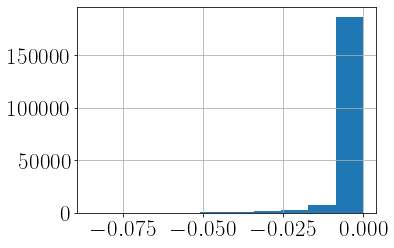

In [642]:
bkgSimInbFD.MM2_epg.hist()

<AxesSubplot:>

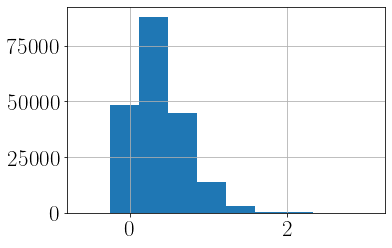

In [652]:
(bkgSimInbFD.Gp - bkgSimInbFD.GenGp).hist()

<AxesSubplot:>

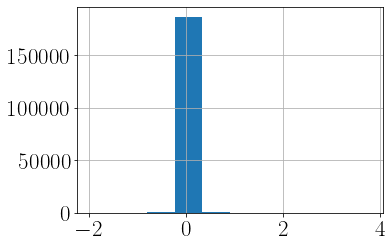

In [674]:
(dvcsSimInbFD.Gp - dvcsSimInbFD.GenGp).hist()

<AxesSubplot:>

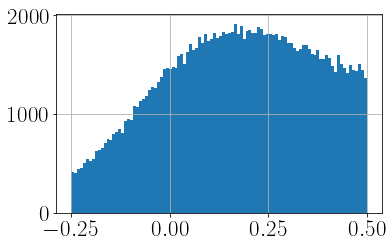

In [689]:
((bkgSimInbFD.nu - bkgSimInbFD.t2/M/2)-bkgSimInbFD.Gp).hist(bins = np.linspace(-0.25, 0.5, 101))


dGp 0.2581305984960068
dPp 0.00864127009690266


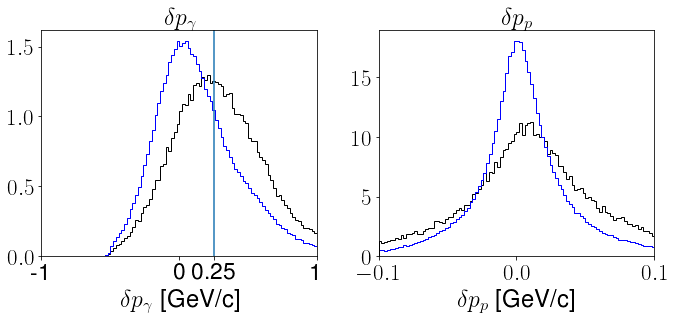

<Figure size 432x288 with 0 Axes>

In [741]:
varstoplot = ["dGp", "dPp"]
title = [r"$\delta p_{\gamma}$", r"$\delta p_{p}$"]
unit = [GeVc, GeVc]
binstarts = [-1, -0.1]
binends = [1, 0.1]
fig, axs = plt.subplots(1, 2, figsize = (10,5))
for yind in range(0, 1):
    for xind in range(0, 2):
        ind = xind
        start = binstarts[ind]
        end = binends[ind]
        bins = np.linspace(start, end, 101)
        simDist_dvpi0, bins = np.histogram(bkgSimInbFD[varstoplot[ind]], bins, density = True)
        simDist_dvcs, bins = np.histogram(dvcsSimInbFD[varstoplot[ind]], bins, density = True)
#         simDist = len_pi0ExpInbFD/len_pi0SimInbFD*simDist_dvpi0 + (len_epgExpInbFD/len_dvcsSimInbFD-len_bkgSimInbFD/len_pi0SimInbFD*len_pi0ExpInbFD/len_dvcsSimInbFD)*simDist_dvcs
        simDist = (1-contFD)*simDist_dvcs + contFD*simDist_dvpi0
        expDist, bins = np.histogram(epgExpInbFD[varstoplot[ind]], bins, density=True)
        bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
        axs[ind].step(bincenters, simDist, where='mid',color='b', linewidth=1)
#         axs[yind, xind].step(bincenters, contFD*simDist_dvpi0, where='mid',color='g', linewidth=1)
#         axs[yind, xind].step(bincenters, (1/len_dvcsSimInbFD-cont_inb_FD/len_dvcsSimInbFD)*len_epgExpInbFD*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[ind].hist(epgExpInbFD[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', density=True, linewidth=1)
#         axs[yind, xind].hist(epgExpInbFD[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', linewidth=1)
#         axs[yind, xind].step(bincenters, expDist - len_pi0ExpInbFD/len_pi0SimInbFD*simDist_dvpi0, where='mid',color='k', linewidth=1)
        print(varstoplot[ind], nphistmean(expDist - len(pi0ExpInbFD)/len(pi0SimInbFD)*simDist_dvpi0, bins))
#         axs[yind, xind].step(bincenters, (1-contFD)*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[ind].set_title(title[ind])
        axs[ind].set_xlim([start, end])
        if (unit[ind]):
            axs[xind].set_xlabel(title[ind]+" [" + unit[ind] +"]")
        else:
            axs[xind].set_xlabel(title[ind])
# axs[0,2].set_xticks([2.2, 2.7, 3.2])
# axs[1,0].set_xticks([0.29, 0.32, 0.35, 0.38])
# axs[1,1].set_xticks([0.23, 0.3, 0.39, 0.52])
# axs[1,2].set_xticks([0, 90, 180, 270, 360])
axs[0].axvline(0.25)
axs[0].set_xticks([-1, 0, 0.25, 1])
axs[0].set_xticklabels([-1, 0, 0.25, 1])
plt.tight_layout()
# plt.savefig("kineFD.pdf")
# plt.savefig("analysisnote/inbending1.pdf")
plt.show()
plt.clf()

dGp 0.23182041887979526
dPp 0.003504908362316784


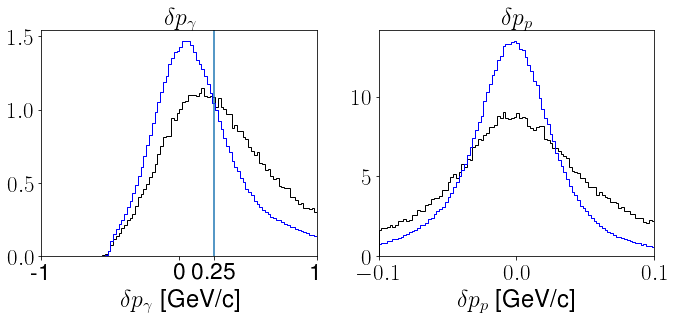

<Figure size 432x288 with 0 Axes>

In [743]:
varstoplot = ["dGp", "dPp"]
title = [r"$\delta p_{\gamma}$", r"$\delta p_{p}$"]
unit = [GeVc, GeVc]
binstarts = [-1, -0.1]
binends = [1, 0.1]
fig, axs = plt.subplots(1, 2, figsize = (10,5))
for yind in range(0, 1):
    for xind in range(0, 2):
        ind = xind
        start = binstarts[ind]
        end = binends[ind]
        bins = np.linspace(start, end, 101)
        simDist_dvpi0, bins = np.histogram(bkgSimInbCD[varstoplot[ind]], bins, density = True)
        simDist_dvcs, bins = np.histogram(dvcsSimInbCD[varstoplot[ind]], bins, density = True)
#         simDist = len_pi0ExpInbFD/len_pi0SimInbFD*simDist_dvpi0 + (len_epgExpInbFD/len_dvcsSimInbFD-len_bkgSimInbFD/len_pi0SimInbFD*len_pi0ExpInbFD/len_dvcsSimInbFD)*simDist_dvcs
        simDist = (1-contCD)*simDist_dvcs + contCD*simDist_dvpi0
        expDist, bins = np.histogram(epgExpInbCD[varstoplot[ind]], bins, density=True)
        bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
        axs[ind].step(bincenters, simDist, where='mid',color='b', linewidth=1)
#         axs[yind, xind].step(bincenters, contFD*simDist_dvpi0, where='mid',color='g', linewidth=1)
#         axs[yind, xind].step(bincenters, (1/len_dvcsSimInbFD-cont_inb_FD/len_dvcsSimInbFD)*len_epgExpInbFD*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[ind].hist(epgExpInbCD[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', density=True, linewidth=1)
#         axs[yind, xind].hist(epgExpInbFD[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', linewidth=1)
#         axs[yind, xind].step(bincenters, expDist - len_pi0ExpInbFD/len_pi0SimInbFD*simDist_dvpi0, where='mid',color='k', linewidth=1)
        print(varstoplot[ind], nphistmean(expDist - len(pi0ExpInbCD)/len(pi0SimInbCD)*simDist_dvpi0, bins))
#         axs[yind, xind].step(bincenters, (1-contFD)*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[ind].set_title(title[ind])
        axs[ind].set_xlim([start, end])
        if (unit[ind]):
            axs[xind].set_xlabel(title[ind]+" [" + unit[ind] +"]")
        else:
            axs[xind].set_xlabel(title[ind])
# axs[0,2].set_xticks([2.2, 2.7, 3.2])
# axs[1,0].set_xticks([0.29, 0.32, 0.35, 0.38])
# axs[1,1].set_xticks([0.23, 0.3, 0.39, 0.52])
# axs[1,2].set_xticks([0, 90, 180, 270, 360])
axs[0].axvline(0.25)
axs[0].set_xticks([-1, 0, 0.25, 1])
axs[0].set_xticklabels([-1, 0, 0.25, 1])
plt.tight_layout()
# plt.savefig("kineFD.pdf")
# plt.savefig("analysisnote/inbending1.pdf")
plt.show()
plt.clf()

<AxesSubplot:>

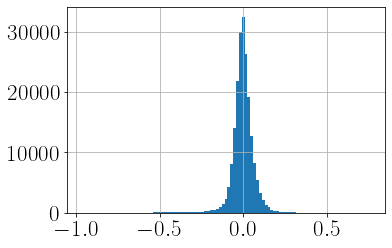

In [726]:
bkgSimInbFD.dPp.hist(bins = 101)

Text(0, 0.5, '$\\delta p_{\\gamma}/p_{\\gamma}$')

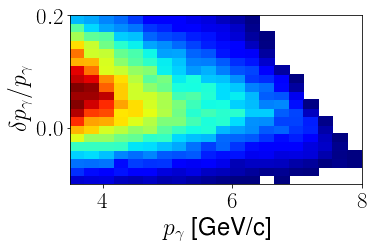

In [784]:
plt.hist2d(epgExpInbFD.Gp, epgExpInbFD.dGp/epgExpInbFD.Gp, bins = [np.linspace(3.5, 8, 21), np.linspace(-0.1, 0.2, 21)], cmap = cmap, cmin = 1)
plt.xlabel(r"$p_{\gamma}$"+ " ["+GeVc+"]")#(epgExpInbFD_noCorr.t2 - epgExpInbFD_noCorr.t1)/2/M
plt.ylabel(r"$\delta p_{\gamma}/p_{\gamma}$")#(epgExpInbFD_noCorr.t2 - epgExpInbFD_noCorr.t1)/2/M

Text(0, 0.5, '$\\delta p_{\\gamma}/p_{\\gamma}$')

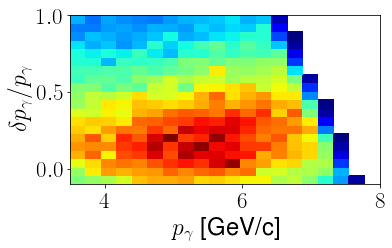

In [783]:
plt.hist2d(epgExpInbCD.Gp, epgExpInbCD.dGp, bins = [np.linspace(3.5, 8, 21), np.linspace(-0.1, 1, 21)], cmap = cmap, cmin = 1)
plt.xlabel(r"$p_{\gamma}$"+ " ["+GeVc+"]")#(epgExpInbFD_noCorr.t2 - epgExpInbFD_noCorr.t1)/2/M
plt.ylabel(r"$\delta p_{\gamma}/p_{\gamma}$")#(epgExpInbFD_noCorr.t2 - epgExpInbFD_noCorr.t1)/2/M

In [1]:
bhphi = [10*i+10 for i in range(36)]


In [2]:
bhphi

[10,
 20,
 30,
 40,
 50,
 60,
 70,
 80,
 90,
 100,
 110,
 120,
 130,
 140,
 150,
 160,
 170,
 180,
 190,
 200,
 210,
 220,
 230,
 240,
 250,
 260,
 270,
 280,
 290,
 300,
 310,
 320,
 330,
 340,
 350,
 360]